## 영화 관객수 예측
### 목표: 영화흥행에 가장 중요한 요소 파악 및 개봉영화 관객 수 예측


#### requirements

In [1]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')
mpl.rc('font', family='Hancom Gothic')
mpl.rc('axes', unicode_minus=False)

from IPython.display import Image


### 0. 컬럼 설명
- 독립변수
    - KOBIS(개봉일람, 2015-2019, 6개월 단위 TOP100위)
    - title : 영화 제목
    - director : 감독 이름
    - distributor(obj) : 배급사
    - distributor_group(obj) : 배급사 카테고리화(매출액 기준)
        - A : 씨제이이엔엠, 메가박스중앙, CGV 아트하우스, 롯데, 쇼박스, 넥스트엔터테인먼트(NEW) 외 관련 합작사
        - B : 월트디즈니, 이십세기폭스, 유니버설픽쳐스, 워너브러더스 코리아, 씨네그루, 이수C&E, 티캐스트, 소니픽쳐스, 스톰픽쳐코리아, 키위컴퍼니, 에이원엔터테이먼트, 셀트리온엔터테인먼트, 케이티하이텔_1건, 관련 합작사
        - C : 아이코닉스, CBS, 홈초이스, 애니플러스, 마운틴픽쳐스, 그 외 소규모 영화사
    - releas_season(obj) : 영화가 개봉한 날의 계절
    - nation(obj, 5개) :
        - 미국, 한국, 영국, 일본, 프랑스, 기타
        - 24개 국적에서 개수 10개 이하 국가를 기타로 통합
    - screen(int) : 영화가 걸렸던 스크린 개수
    - genre(obj, 14개) :
        - 액션, 드라마, 사극, 코미디, 애니메이션, 스릴러, 멜로/로멘스, 범죄, 어드벤처, 다큐멘터리, 미스터리, SF, 공포, 판타지
        - 기존 19개 장르에서 개수 10개 미만 소수 장르 통합
    - rate(obj) : 영화등급
        - 전체관람가
        - 12세 이상
        - 15세 이상
        - 청소년 관람불가
    - director_power(float) : 해당 영화의 개봉년 기준 3년 내 연출한 영화들의 관람객(2012-2019) 총 합(동명이인 체크)
    - actor_power(int) : 해당 영화의 개봉년 기준 3년 내 주연 출연한 영화들의 관람객(2012-2019) 총 합(동명이인 체크)
    ------------------------------------------------------------------------------------------------------------------------------------
    - 크롤링(네이버 뉴스, 영화 사이트)으로 얻은 자료
    - audience_rating(float) : 네이버 영화 사이트 관람객 평점(개봉 1주일 내)
    - rating_audiences(int) : 네이버 영화 사이트에서 평점을 매긴 관람객 수(개봉 1주일 내)
    - actor_power(int) : 개봉년 기준 3년 내 주연 출연한 영화들의 관람객 총 합
    - news(int) : 개봉 1주일 전후 해당 영화 관련 기사
    - 리서치로 얻은 자료
    - sequel(boolean) : 시리즈물 여부(boolean(binomiel))
    - original(boolean) : 원작(책, 소설, 영상물) 존재, 실화 여부
- 종속변수
    - aud_nationwide : 전국관객수(한국에서의 영화흥행기준)

### 1. Data 불러오기

In [139]:
X_train = pd.read_csv('../final_df_13/X_train_13.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv('../final_df_13/y_train_13.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv('../final_df_13/X_test_13.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv('../final_df_13/y_test_13.csv').drop(columns='Unnamed: 0')

In [3]:
df_train_13 = pd.concat([X_train, y_train], axis=1)
df_test_13 = pd.concat([X_test, y_test], axis=1)

df_final_13 = pd.concat([df_train_13, df_test_13], axis=0)

In [4]:
df_final_09 = pd.read_csv('./data_09.csv').drop(columns='Unnamed: 0')

In [5]:
df_final_02 = pd.read_csv("../yeejun/final_df_02.csv").drop(columns='Unnamed: 0')

In [6]:
df_final_03 = pd.read_csv("../final_df_03_ols.csv")
df_final_03 = df_final_03.drop("Unnamed: 0", axis=1)

### 2. EDA

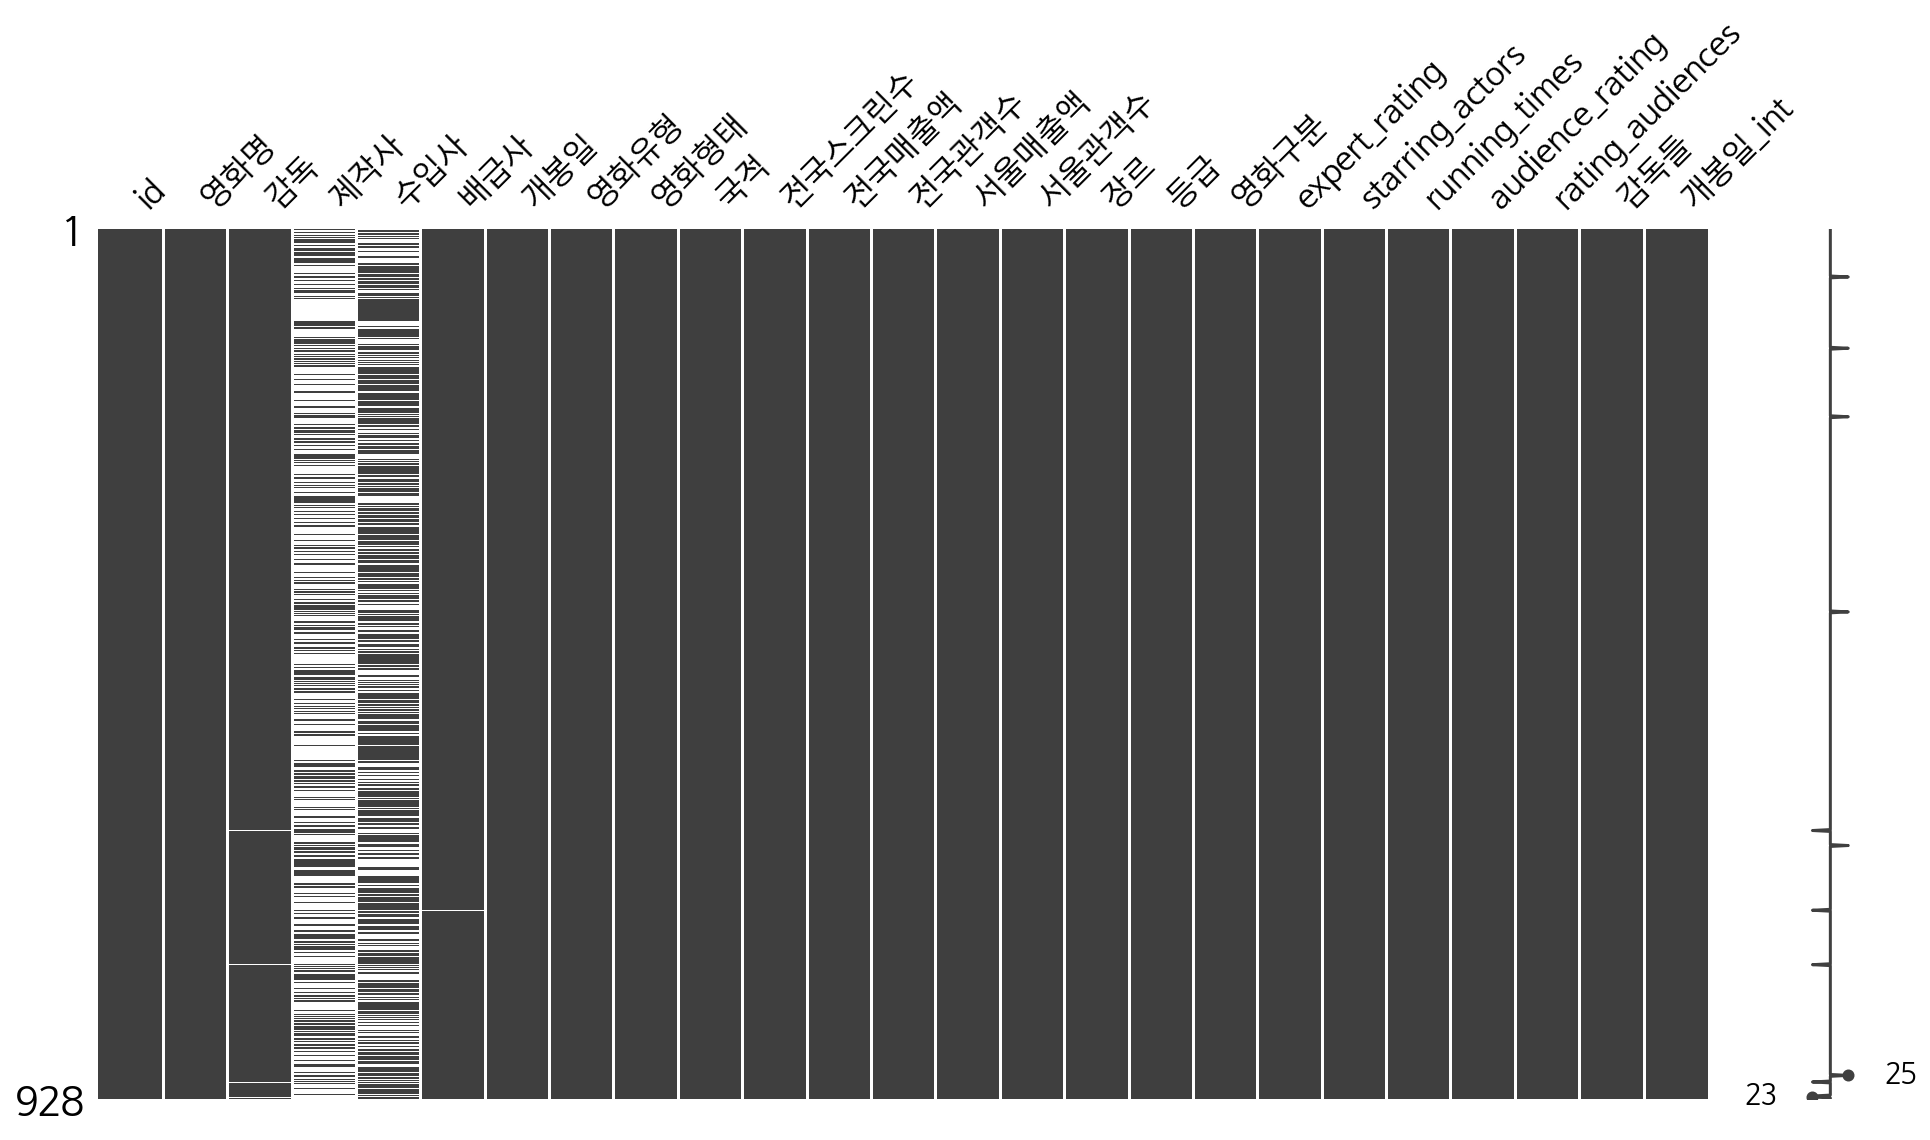

In [7]:
msno.matrix(df_final_02, figsize=(16, 8))
plt.show()

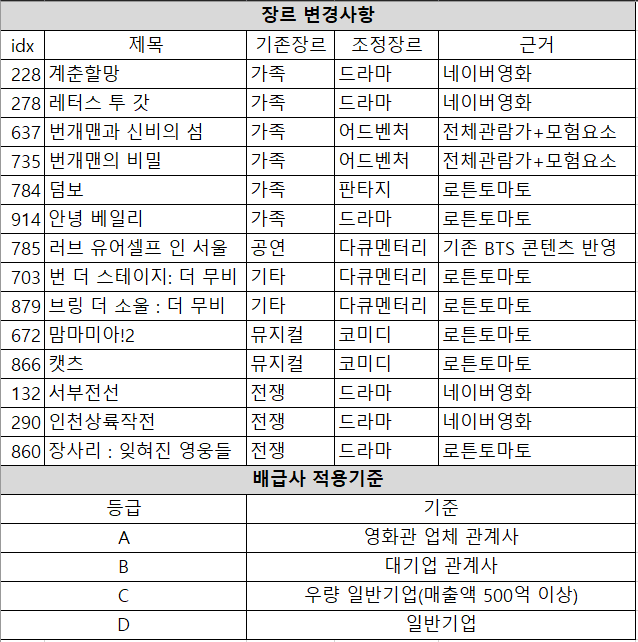

In [73]:
Image("./bitna\distributor_criteria.PNG")

#### 카테고리 컬럼 정리

In [8]:
df_distributor = df_final_03.groupby('배급사').size().reset_index()
df_distributor = df_distributor.rename(columns={0:'count'})
df_distributor_sort = df_distributor.sort_values('count', ascending=False)
df_distributor_sort = df_distributor_sort.reset_index().drop('index', axis=1)
df_distributor_sort

배급사  count
0                  씨제이이앤엠(주)     85
1        유니버설픽쳐스인터내셔널 코리아(유)     77
2        (주)넥스트엔터테인먼트월드(NEW)     67
3              워너브러더스 코리아(주)     63
4              롯데쇼핑㈜롯데엔터테인먼트     52
..                       ...    ...
135                  (주)시네마달      1
136  (주)스톰픽쳐스코리아,주식회사 우리네트웍스      1
137  (주)스톰픽쳐스코리아,(주)페퍼민트앤컴퍼니      1
138       (주)스마일이엔티,(주)영화사오원      1
139         힘컨텐츠(주),(주)디스테이션      1

[140 rows x 2 columns]

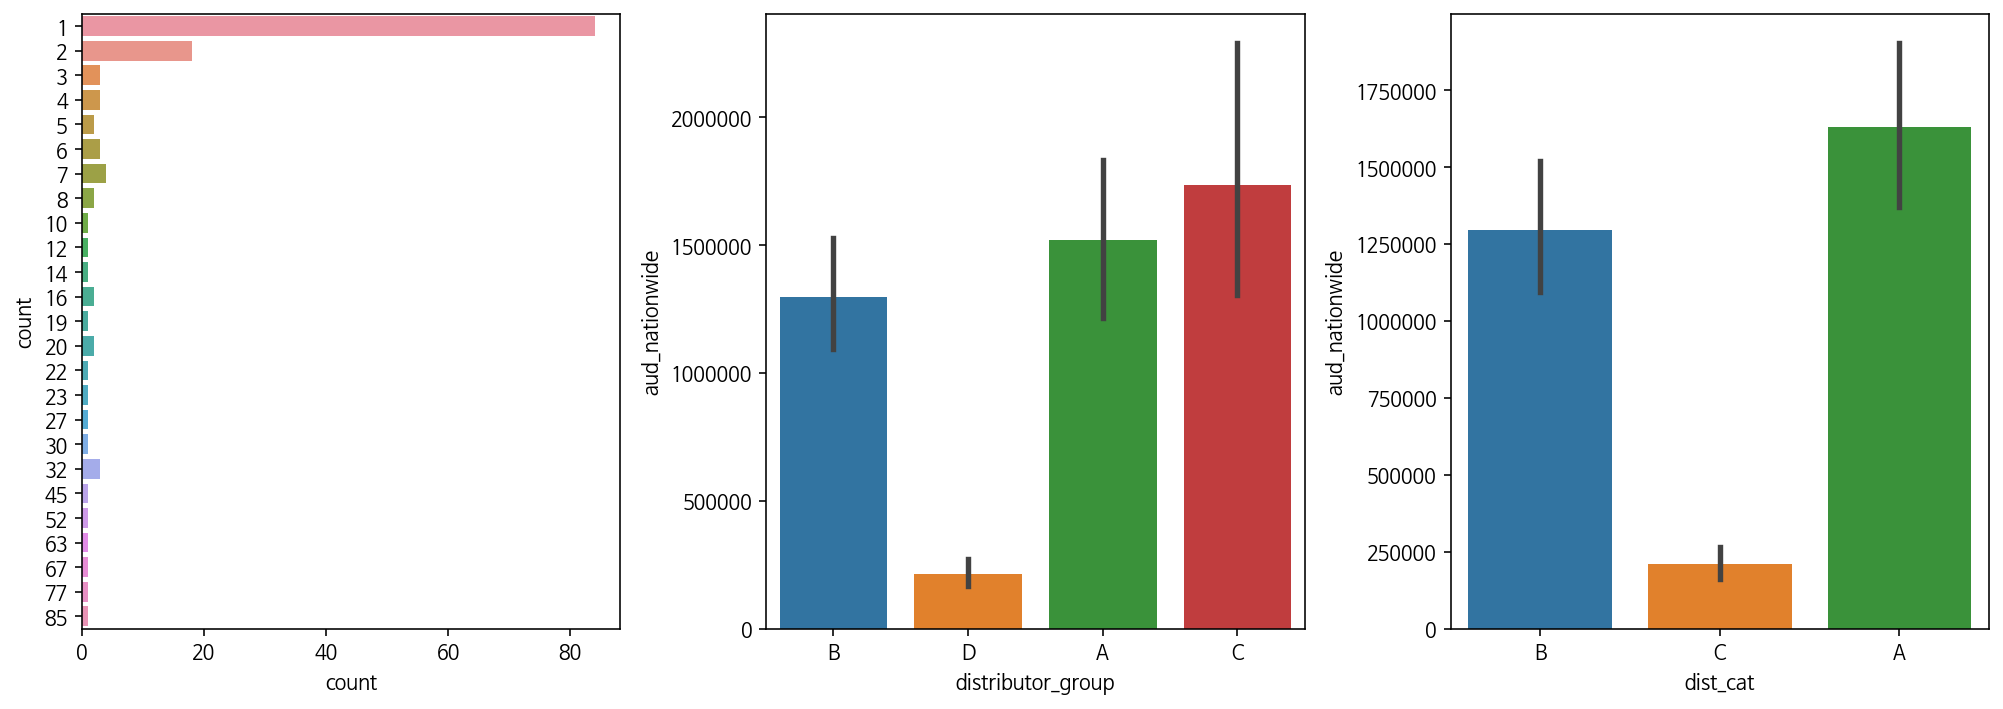

In [9]:
#### 배급사 그룹화 정리
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.countplot(y='count', data=df_distributor_sort)

plt.subplot(132)
sns.barplot(x=df_final_09["distributor_group"], y=df_final_09["aud_nationwide"])

plt.subplot(133)
sns.barplot(x=df_final_13["dist_cat"], y=df_final_13["aud_nationwide"])

plt.tight_layout()


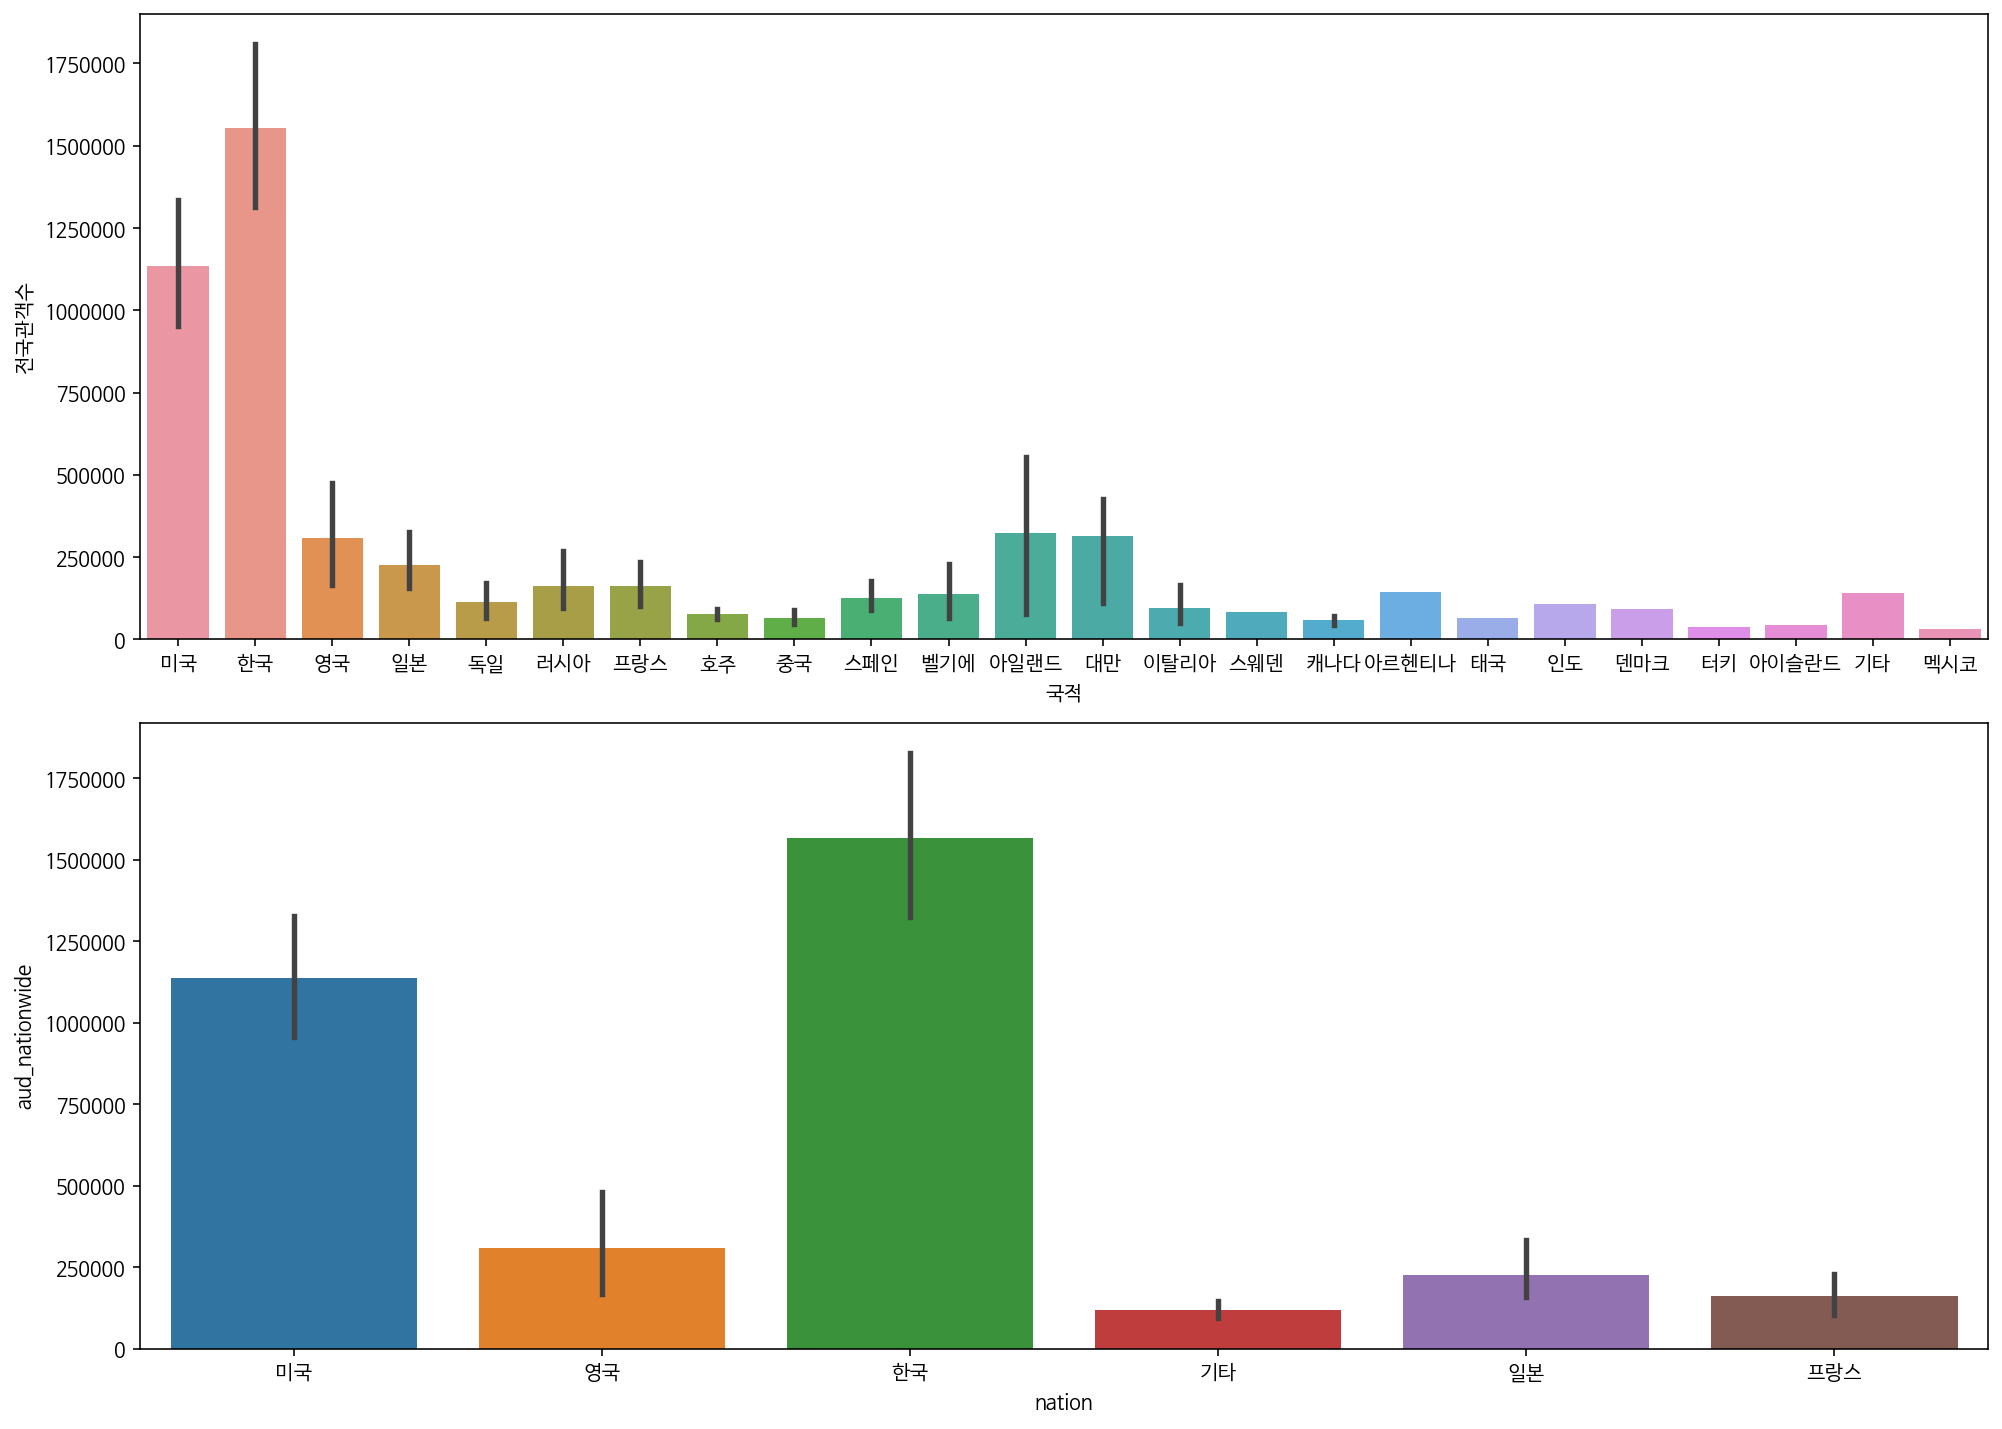

In [10]:
#### 국적 정리
plt.figure(figsize=(14, 10))

plt.subplot(211)
sns.barplot(x=df_final_03["국적"], y=df_final_03["전국관객수"])

plt.subplot(212)
sns.barplot(x=df_final_09["nation"], y=df_final_09["aud_nationwide"])

plt.tight_layout()
plt.show()

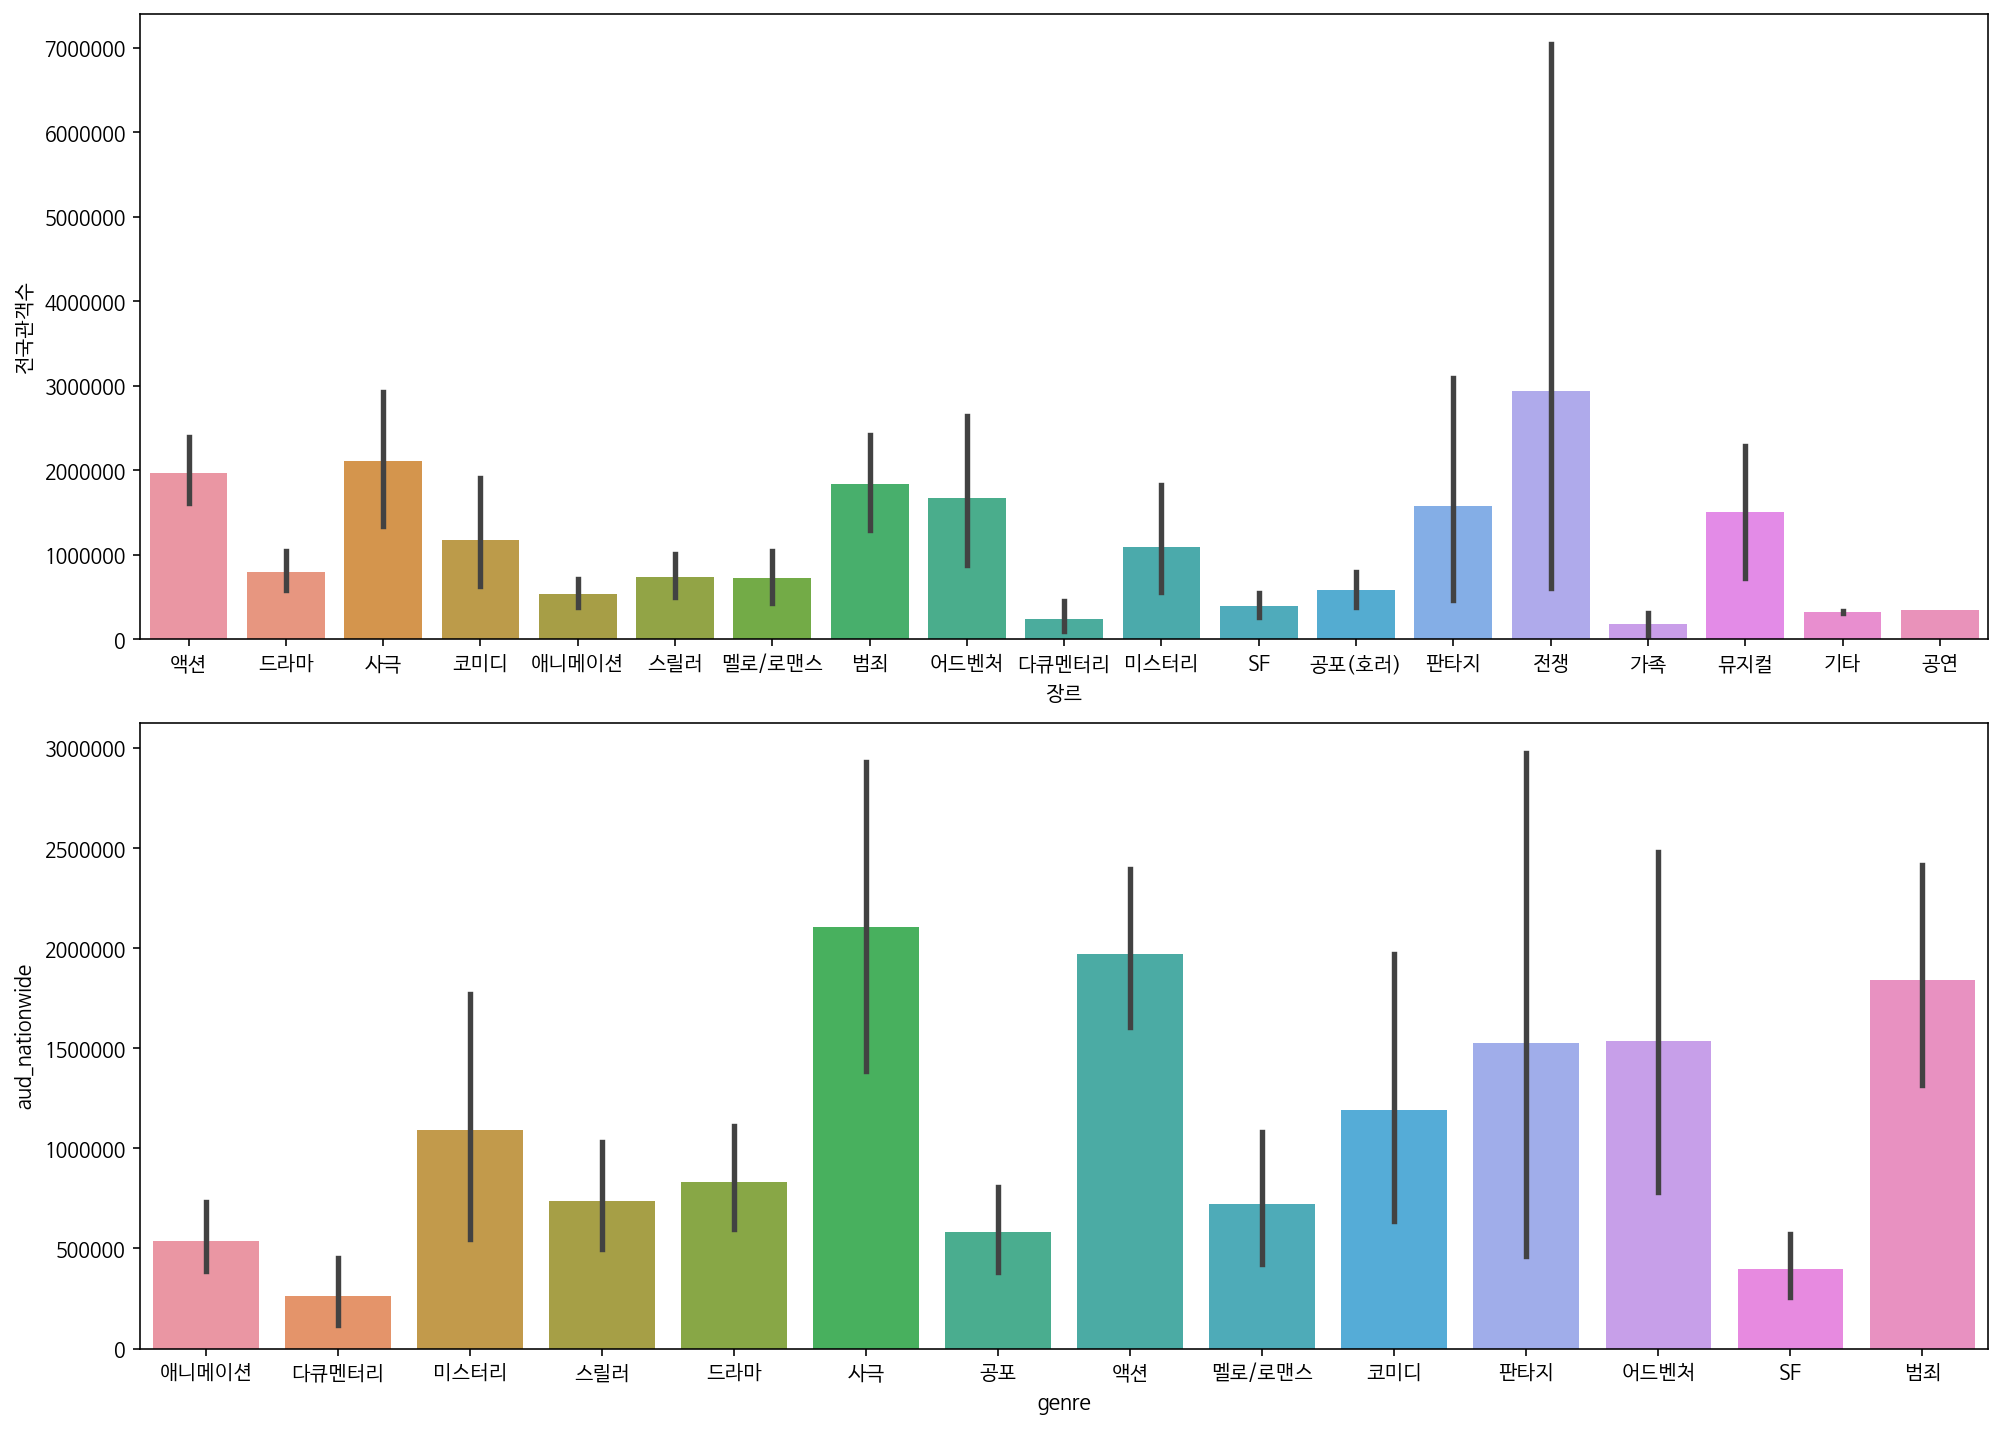

In [16]:
#### 장르 정리
plt.figure(figsize=(14, 10))

plt.subplot(211)
sns.barplot(x=df_final_03["장르"], y=df_final_03["전국관객수"])

plt.subplot(212)
sns.barplot(x=df_final_09["genre"], y=df_final_09["aud_nationwide"])

plt.tight_layout()
plt.show()

#### sequel & original 컬럼 추가

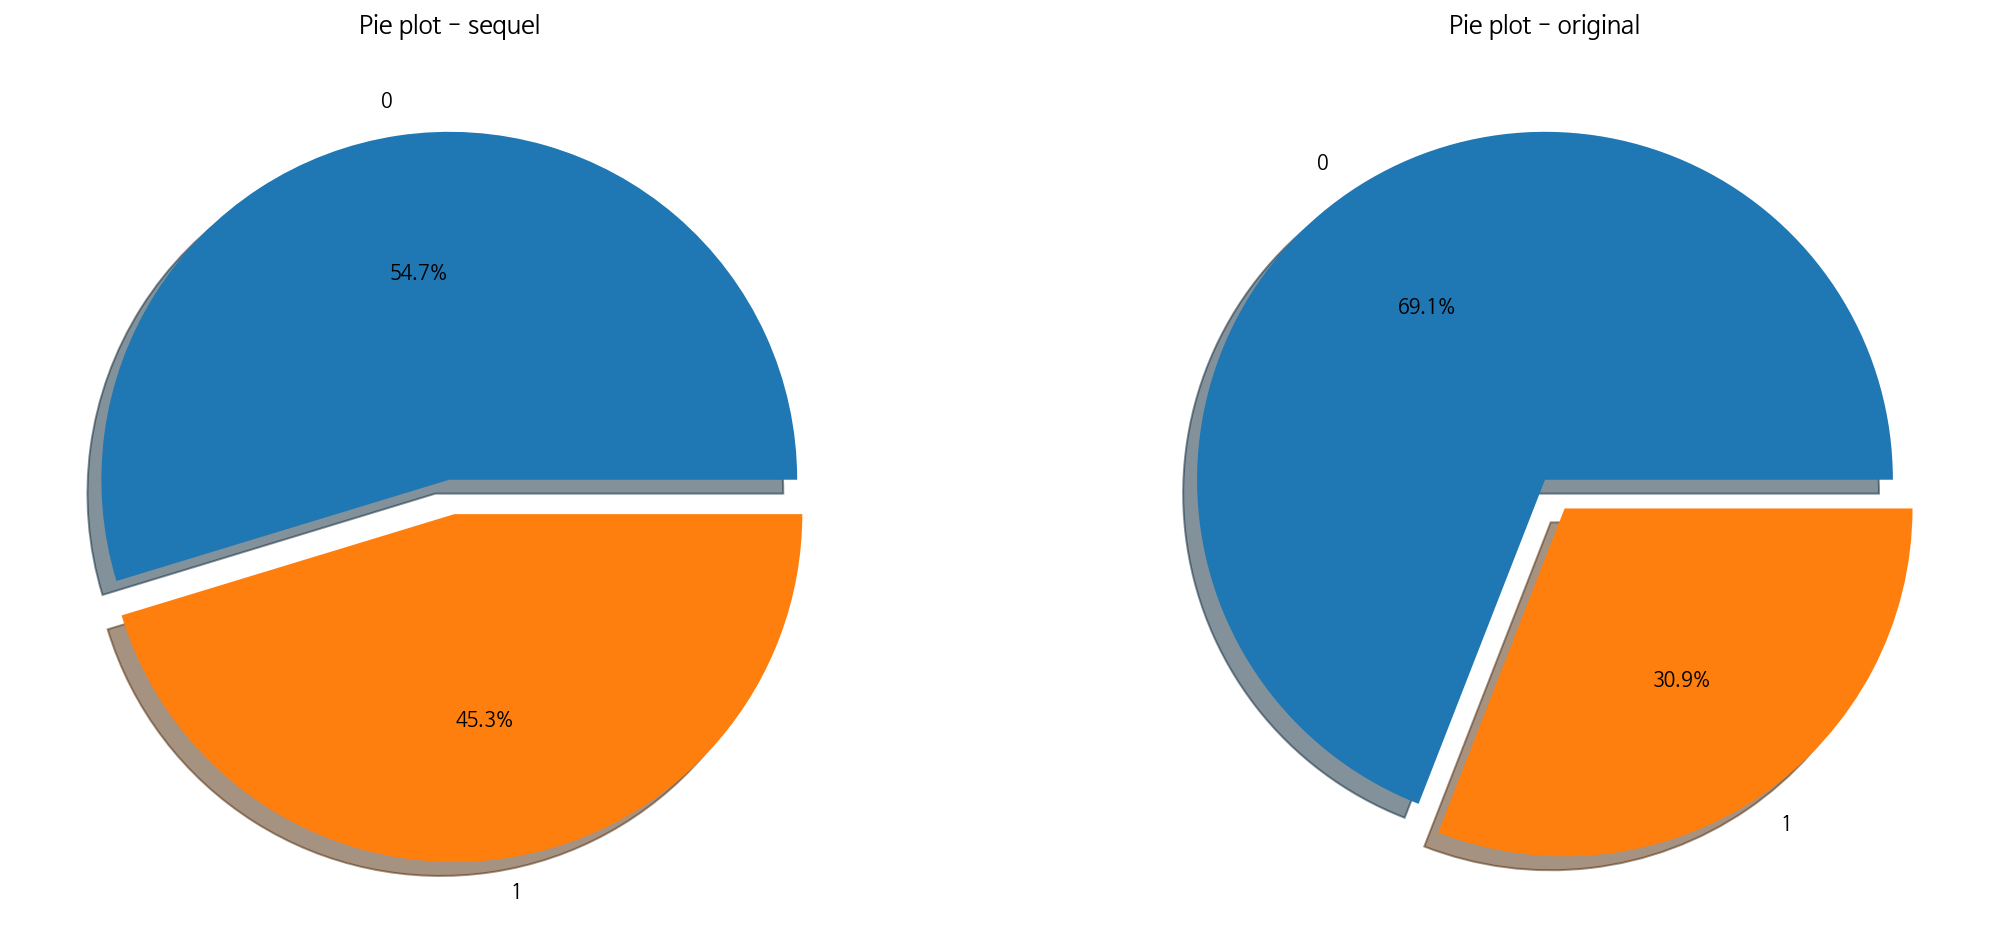

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_final_13['sequel'].value_counts().plot.pie(explode=[0, 0.1],
                                                  autopct='%1.1f%%', ax=ax[0], shadow=True)
df_final_13['original'].value_counts().plot.pie(explode=[0, 0.1],
                                                   autopct='%1.1f%%', ax=ax[1], shadow=True)
ax[0].set_title('Pie plot - sequel')
ax[0].set_ylabel('')
ax[1].set_title('Pie plot - original')
ax[1].set_ylabel('')

plt.show()

#### 최종 데이터
카테고리 변수 중 감독(2개), 배급사(1개) 결측 데이터 제거 후 총 925개

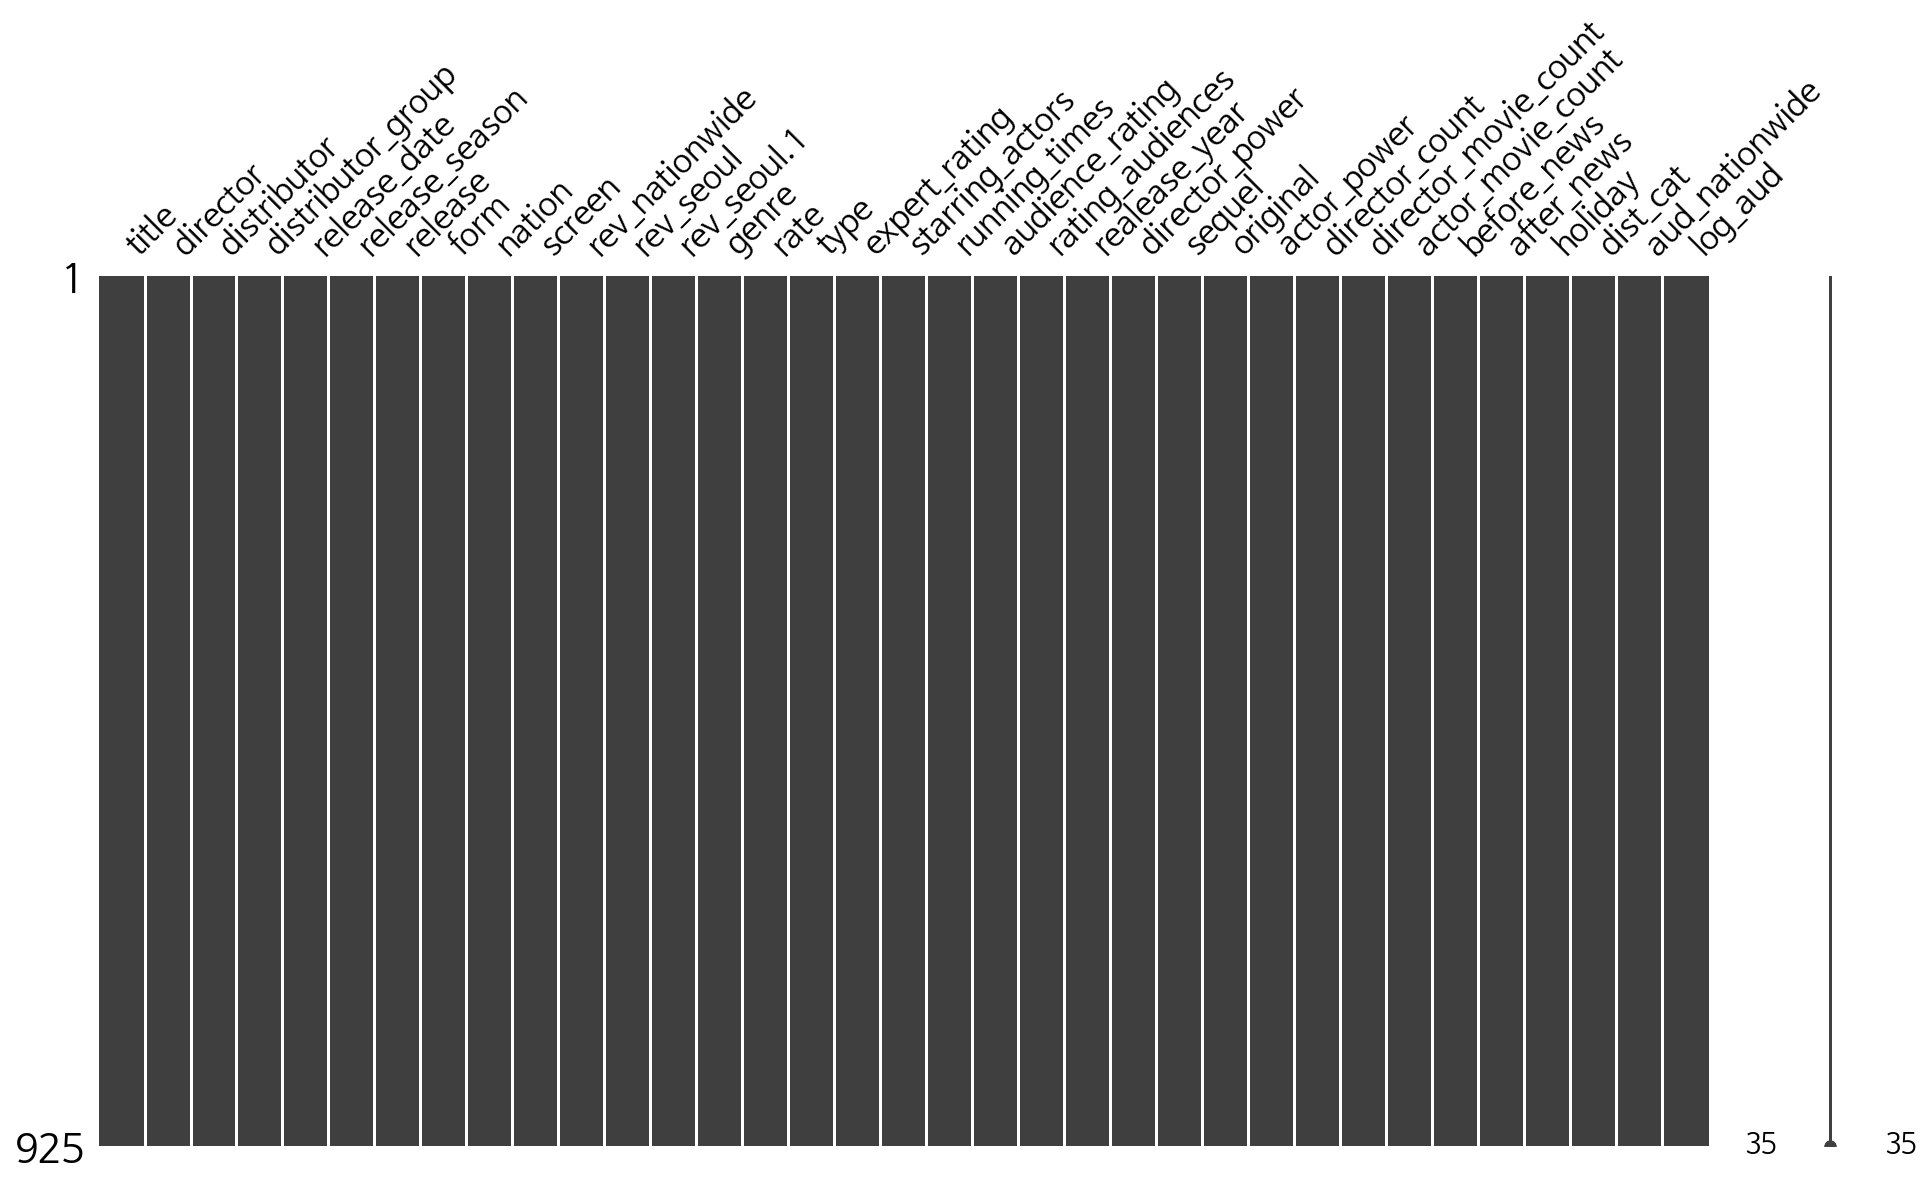

In [12]:
msno.matrix(df_final_13, figsize=(16, 8))
plt.show()

In [13]:
df_final_13.describe()

release_date       screen  rev_nationwide     rev_seoul   rev_seoul.1  \
count  9.250000e+02   925.000000    9.250000e+02  9.250000e+02  9.250000e+02   
mean   2.017023e+07   615.031351    8.986493e+09  2.420606e+09  2.839164e+05   
std    1.435678e+04   419.167442    1.664960e+10  4.372609e+09  5.045390e+05   
min    2.014111e+07    28.000000    2.519903e+08  3.015330e+07  4.068000e+03   
25%    2.016030e+07   322.000000    7.617593e+08  2.454462e+08  3.006200e+04   
50%    2.017061e+07   512.000000    2.246950e+09  6.281424e+08  7.632900e+04   
75%    2.018092e+07   827.000000    8.881616e+09  2.286908e+09  2.748960e+05   
max    2.019123e+07  2835.000000    1.396400e+11  3.346972e+10  3.638287e+06   

       expert_rating  running_times  audience_rating  rating_audiences  \
count     925.000000     925.000000       925.000000        925.000000   
mean        5.400735     109.778378         8.166960        673.470270   
std         2.048343      19.932613         1.492485       1386.145334   
min         0.000000      48.000000         0.000000          0.000000   
25%         5.000000      97.000000         7.867150         81.000000   
50%         5.920000     110.000000         8.457944        234.000000   
75%         6.700000     122.000000         8.919948        696.000000   
max         9.110000     222.000000        10.000000      24610.000000   

       realease_year  ...    original   actor_power  director_count  \
count     925.000000  ...  925.000000  9.250000e+02      925.000000   
mean     2016.956757  ...    0.309189  1.007723e+07        1.084324   
std         1.436337  ...    0.462409  1.477958e+07        0.300473   
min      2014.000000  ...    0.000000  0.000000e+00        1.000000   
25%      2016.000000  ...    0.000000  3.709810e+05        1.000000   
50%      2017.000000  ...    0.000000  4.022897e+06        1.000000   
75%      2018.000000  ...    1.000000  1.323411e+07        1.000000   
max      2019.000000  ...    1.000000  1.278038e+08        4.000000   

       director_movie_count  actor_movie_count  before_news   after_news  \
count            925.000000         925.000000   925.000000   925.000000   
mean               0.611892           6.184865   356.567568   381.874595   
std                0.924457           5.224131   615.752286   443.010890   
min                0.000000           0.000000     0.000000     0.000000   
25%                0.000000           2.000000    23.000000    82.000000   
50%                0.000000           5.000000    59.000000   222.000000   
75%                1.000000           9.000000   424.000000   539.000000   
max                7.000000          32.000000  5514.000000  3662.000000   

          holiday  aud_nationwide     log_aud  
count  925.000000    9.250000e+02  925.000000  
mean     0.062703    1.099422e+06   12.765999  
std      0.242559    2.009962e+06    1.500650  
min      0.000000    3.186600e+04   10.369295  
25%      0.000000    9.701700e+04   11.482641  
50%      0.000000    2.860420e+05   12.563894  
75%      0.000000    1.124815e+06   13.933129  
max      1.000000    1.626336e+07   16.604425  

[8 rows x 22 columns]

In [14]:
df_final_13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 0 to 184
Data columns (total 35 columns):
title                   925 non-null object
director                925 non-null object
distributor             925 non-null object
distributor_group       925 non-null object
release_date            925 non-null int64
release_season          925 non-null object
release                 925 non-null object
form                    925 non-null object
nation                  925 non-null object
screen                  925 non-null int64
rev_nationwide          925 non-null float64
rev_seoul               925 non-null int64
rev_seoul.1             925 non-null int64
genre                   925 non-null object
rate                    925 non-null object
type                    925 non-null object
expert_rating           925 non-null float64
starring_actors         925 non-null object
running_times           925 non-null int64
audience_rating         925 non-null float64
rating_audiences 

### 3. 상관관계 조사

#### pairplot

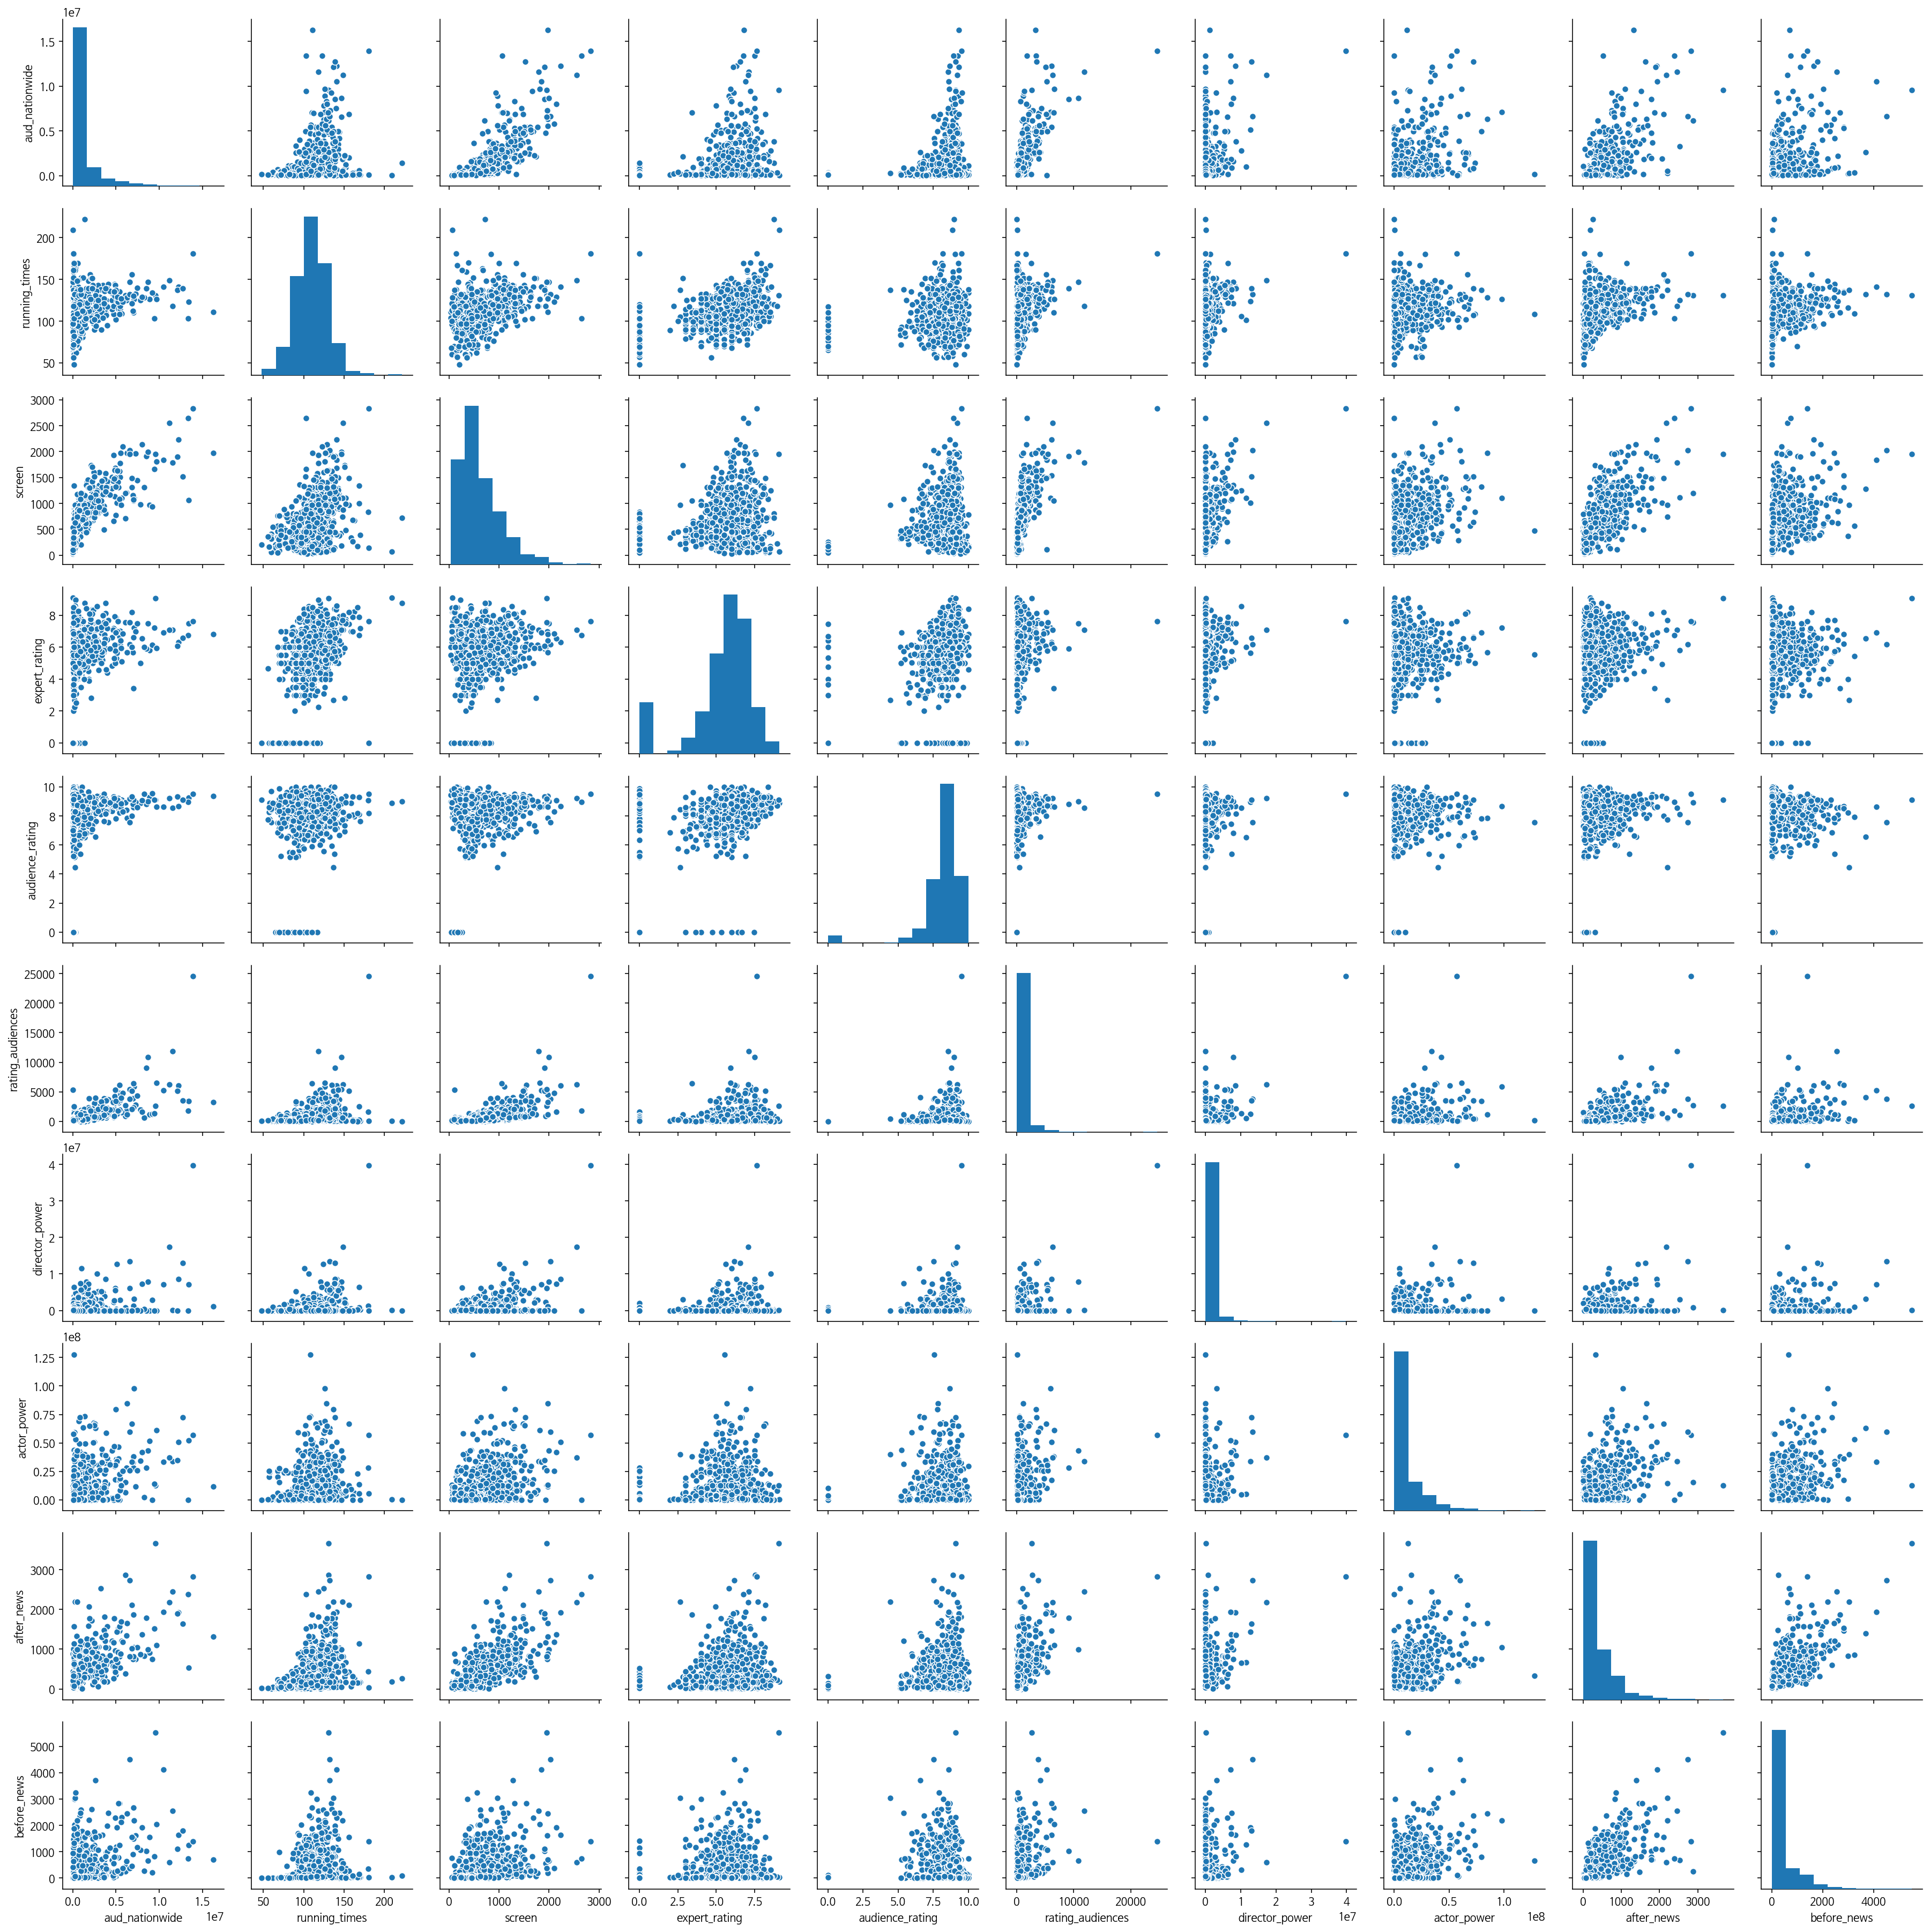

In [23]:
sns.pairplot(df_final_13[['aud_nationwide', 'running_times', 'screen', 'expert_rating', 'audience_rating', 'rating_audiences', 'director_power', 'actor_power', 'after_news', 'before_news']])
plt.show()

#### 히트맵으로 수치형 데이터 상관관계 파악
- 스크린수(screen)와 평점을 매긴 관객수(rating_audiensces)가 관객수(aud_nationwide)와 높은 상관관계를 갖는다.
- 개봉전 뉴스 건수(before_news)와 관객수(aud_nationwide)는 상관계수가 0이다.
- 감독파워(director_power), 스타파워(actor_power)는 관객수와 상관계수가 0.5이다.
- 평점을 매긴 관객수(rating_audiences)와 스크린수(screen)의 상관계수가 0.7이다. (다중공선성 주의)
- 개봉전 기사 건수(before_news)와 개봉후 기사 건수(after_news)의 상관계수가 0.9이다. (다중공선성 주의)
- 평점을 매긴 관객수(audience_rating)와 감독파워(director_power)의 상관계수가 0.7이다. (다중공선성 주의)

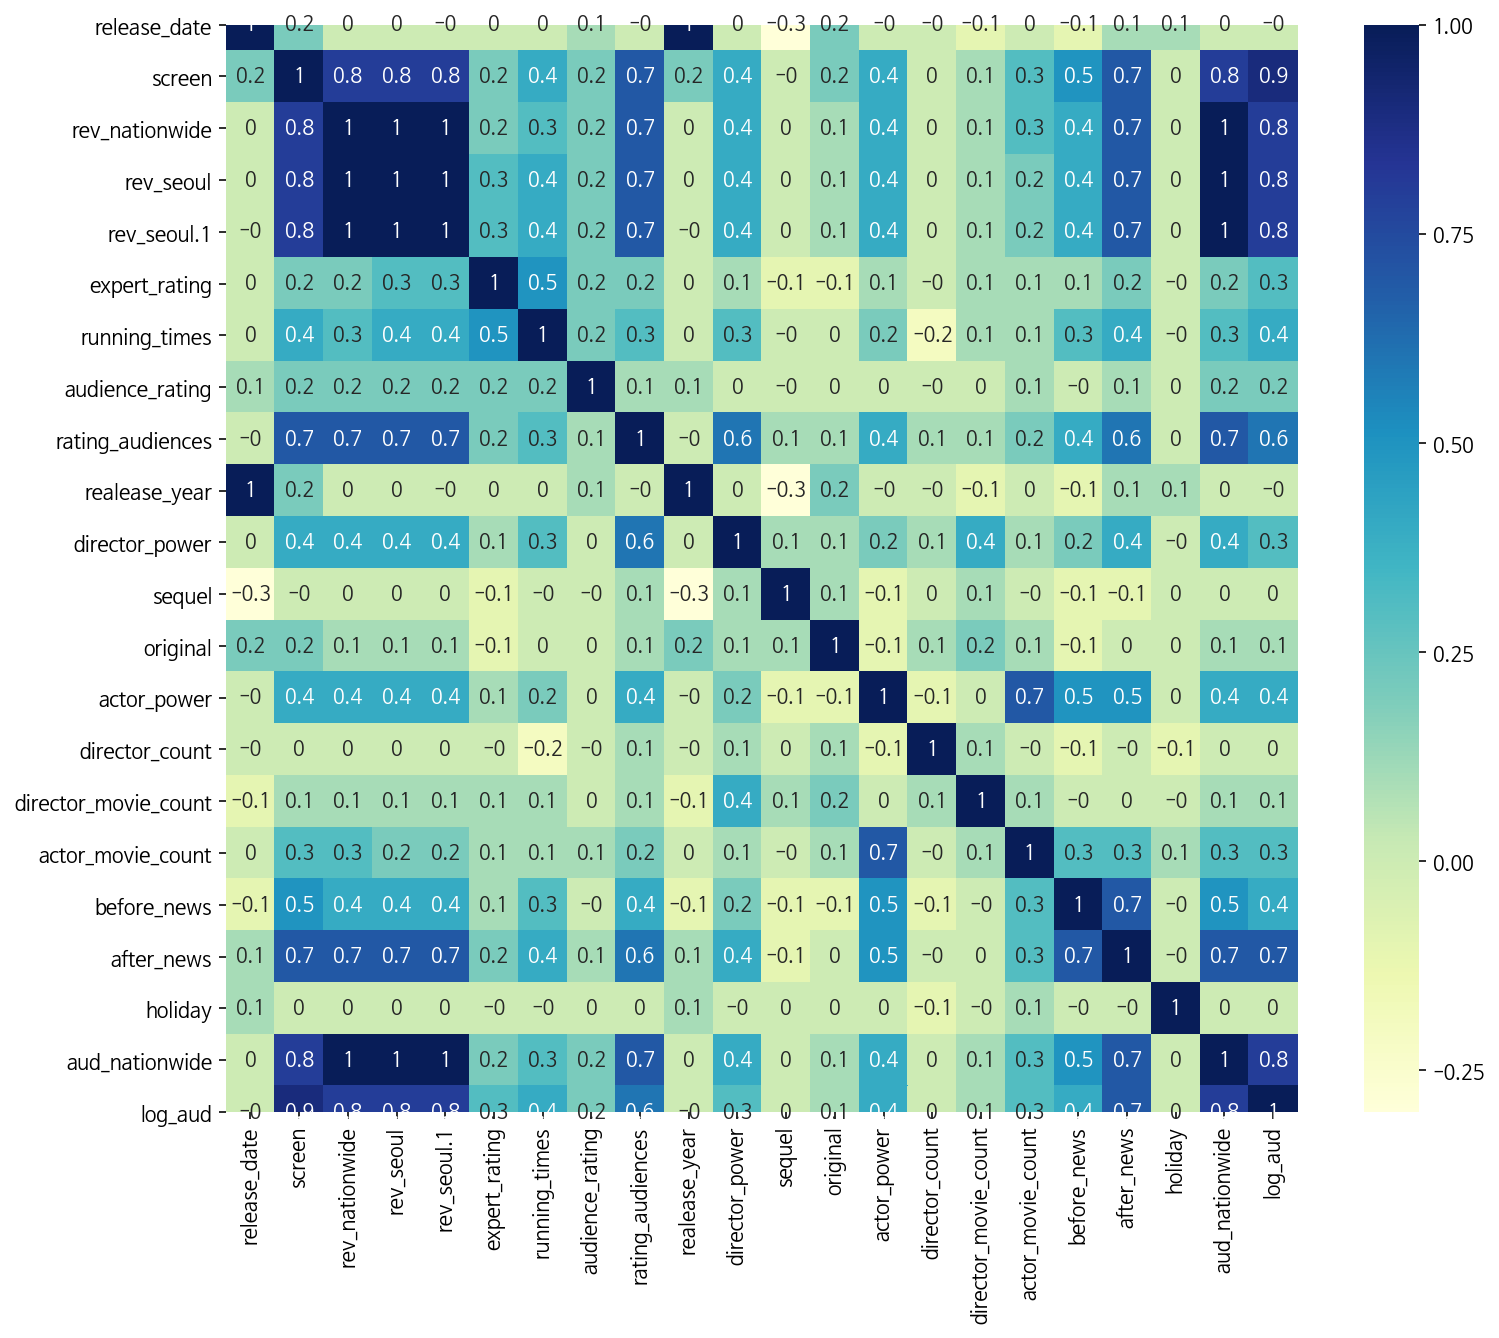

In [24]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_final_13.corr().round(1)
sns.heatmap(data=correlation_matrix, annot=True, cmap="YlGnBu")
plt.show()

#### 카테고리 변수화 전국관객수와의 관계 파악

In [7]:
df = df_final_13

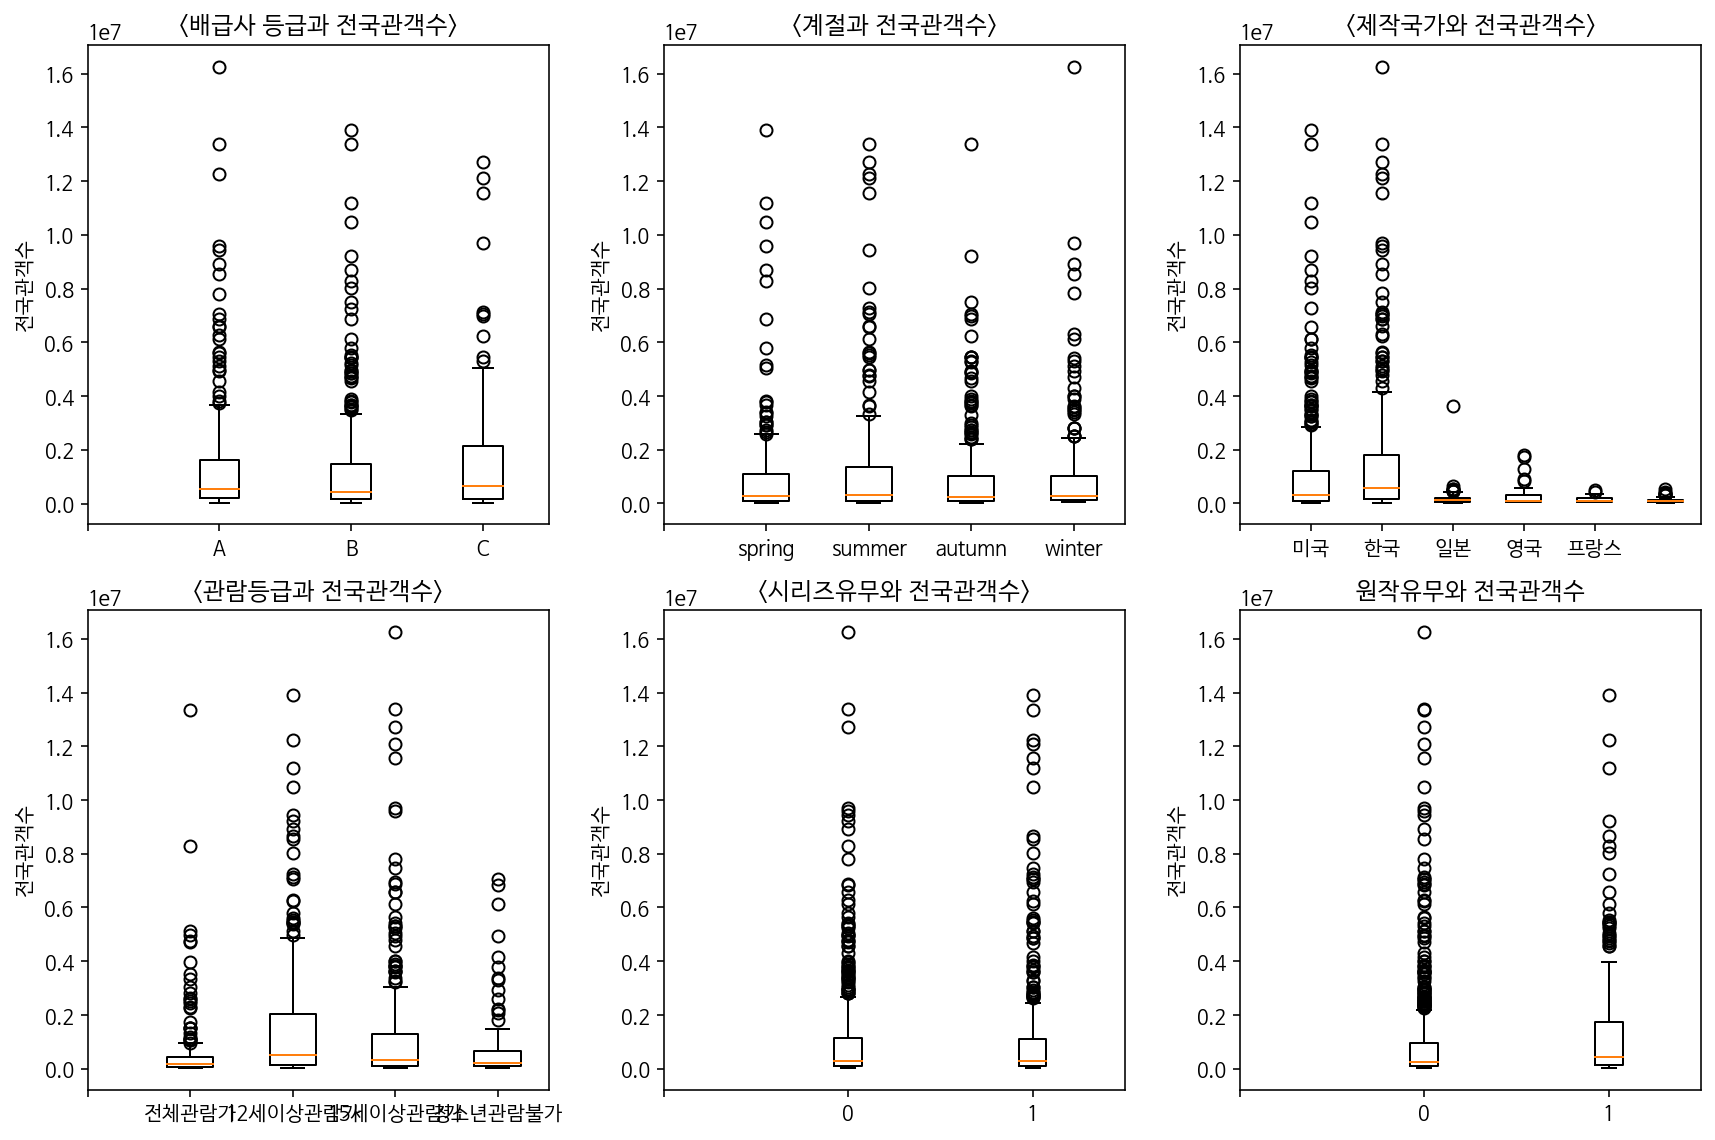

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.boxplot((df[df['distributor_group'] == 'A']['aud_nationwide'], df[df['distributor_group'] == 'B']['aud_nationwide'], 
             df[df['distributor_group'] == 'C']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(4), (' ', 'A', 'B', 'C'))
plt.title("<배급사 등급과 전국관객수>")

plt.subplot(232)
plt.boxplot((df[df['release_season'] == 'spring']['aud_nationwide'], df[df['release_season'] == 'summer']['aud_nationwide'], 
             df[df['release_season'] == 'autumn']['aud_nationwide'], df[df['release_season'] == 'winter']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(5), (' ', 'spring', 'summer', 'autumn', 'winter'))
plt.title("<계절과 전국관객수>")

plt.subplot(233)
plt.boxplot((df[df['nation'] == '미국']['aud_nationwide'], df[df['nation'] == '한국']['aud_nationwide'], df[df['nation'] == '일본']['aud_nationwide'],
            df[df['nation'] == '영국']['aud_nationwide'], df[df['nation'] == '프랑스']['aud_nationwide'], df[df['nation'] == '기타']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(6), (' ', '미국', '한국', '일본', '영국', '프랑스', '기타'))
plt.title("<제작국가와 전국관객수>")

plt.subplot(234)
plt.boxplot((df[df['rate'] == '전체관람가']['aud_nationwide'], df[df['rate'] == '12세이상관람가']['aud_nationwide'], 
             df[df['rate'] == '15세이상관람가']['aud_nationwide'], df[df['rate'] == '청소년관람불가']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(5), (' ', '전체관람가', '12세이상관람가', '15세이상관람가', '청소년관람불가'))
plt.title("<관람등급과 전국관객수>")

plt.subplot(235)
plt.boxplot((df[df['sequel'] == 0]['aud_nationwide'], df[df['sequel'] == 1]['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(3), (' ', '0', '1'))
plt.title("<시리즈유무와 전국관객수>")

plt.subplot(236)
plt.boxplot((df[df['original'] == 0]['aud_nationwide'], df[df['original'] == 1]['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(3), (' ', '0', '1'))
plt.title("원작유무와 전국관객수")

plt.tight_layout ()
plt.show()

In [76]:
modelA = sm.OLS.from_formula("log_aud ~ dist_cat + release_season + nation + rate + C(sequel) + C(original) +  C(holiday)", data=df_train_13)
resultA = modelA.fit()
print(resultA.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     27.83
Date:                Wed, 08 Apr 2020   Prob (F-statistic):           9.49e-65
Time:                        12:02:02   Log-Likelihood:                -1170.0
No. Observations:                 740   AIC:                             2374.
Df Residuals:                     723   BIC:                             2452.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [77]:
sm.stats.anova_lm(resultA)

df       sum_sq     mean_sq           F        PR(>F)
dist_cat          2.0   431.654793  215.827397  152.466410  5.665571e-56
release_season    3.0     3.429959    1.143320    0.807672  4.898045e-01
nation            5.0   108.934823   21.786965   15.390911  2.126583e-14
rate              3.0    57.911710   19.303903   13.636808  1.162072e-08
C(sequel)         1.0     8.433926    8.433926    5.957957  1.488994e-02
C(original)       1.0    16.186003   16.186003   11.434237  7.598079e-04
C(holiday)        1.0     3.796837    3.796837    2.682190  1.019112e-01
Residual        723.0  1023.459579    1.415573         NaN           NaN

In [80]:
predA =  resultA.predict(X_test[["dist_cat", "release_season", "nation", "rate", "sequel", "original", "holiday"]])
rssA = ((y_test.log_aud - predA) ** 2).sum()
tssA = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredA = 1 - rssA/tssA
rsquaredA

0.28834662891344087

#### 카테고리 변수들간 상관관계 히트맵

In [137]:
dist_df = pd.get_dummies(df['distributor_group'], prefix='dist')
season_df = pd.get_dummies(df['release_season'], prefix='season')
nation_df = pd.get_dummies(df['nation'], prefix='nation')
rate_df = pd.get_dummies(df['rate'], prefix='rate')
sequel_df = pd.get_dummies(df['sequel'], prefix='sequel')
original_df  = pd.get_dummies(df['original'], prefix='original')
genre_df = pd.get_dummies(df['genre'], prefix='genre')

dummies_df = pd.concat((dist_df, season_df, nation_df, rate_df, sequel_df, original_df, genre_df), axis=1)


correlation_matrix_cat = dummies_df.corr().round(1)

- 한국과 미국 -0.7 (경쟁관계)
- 애니메이션 전체관람가 0.8 / 애니메이션과 일본 0.4
- 상영시간과 전체관람가 0.5 / 상영시간과 애니메이션 0.5

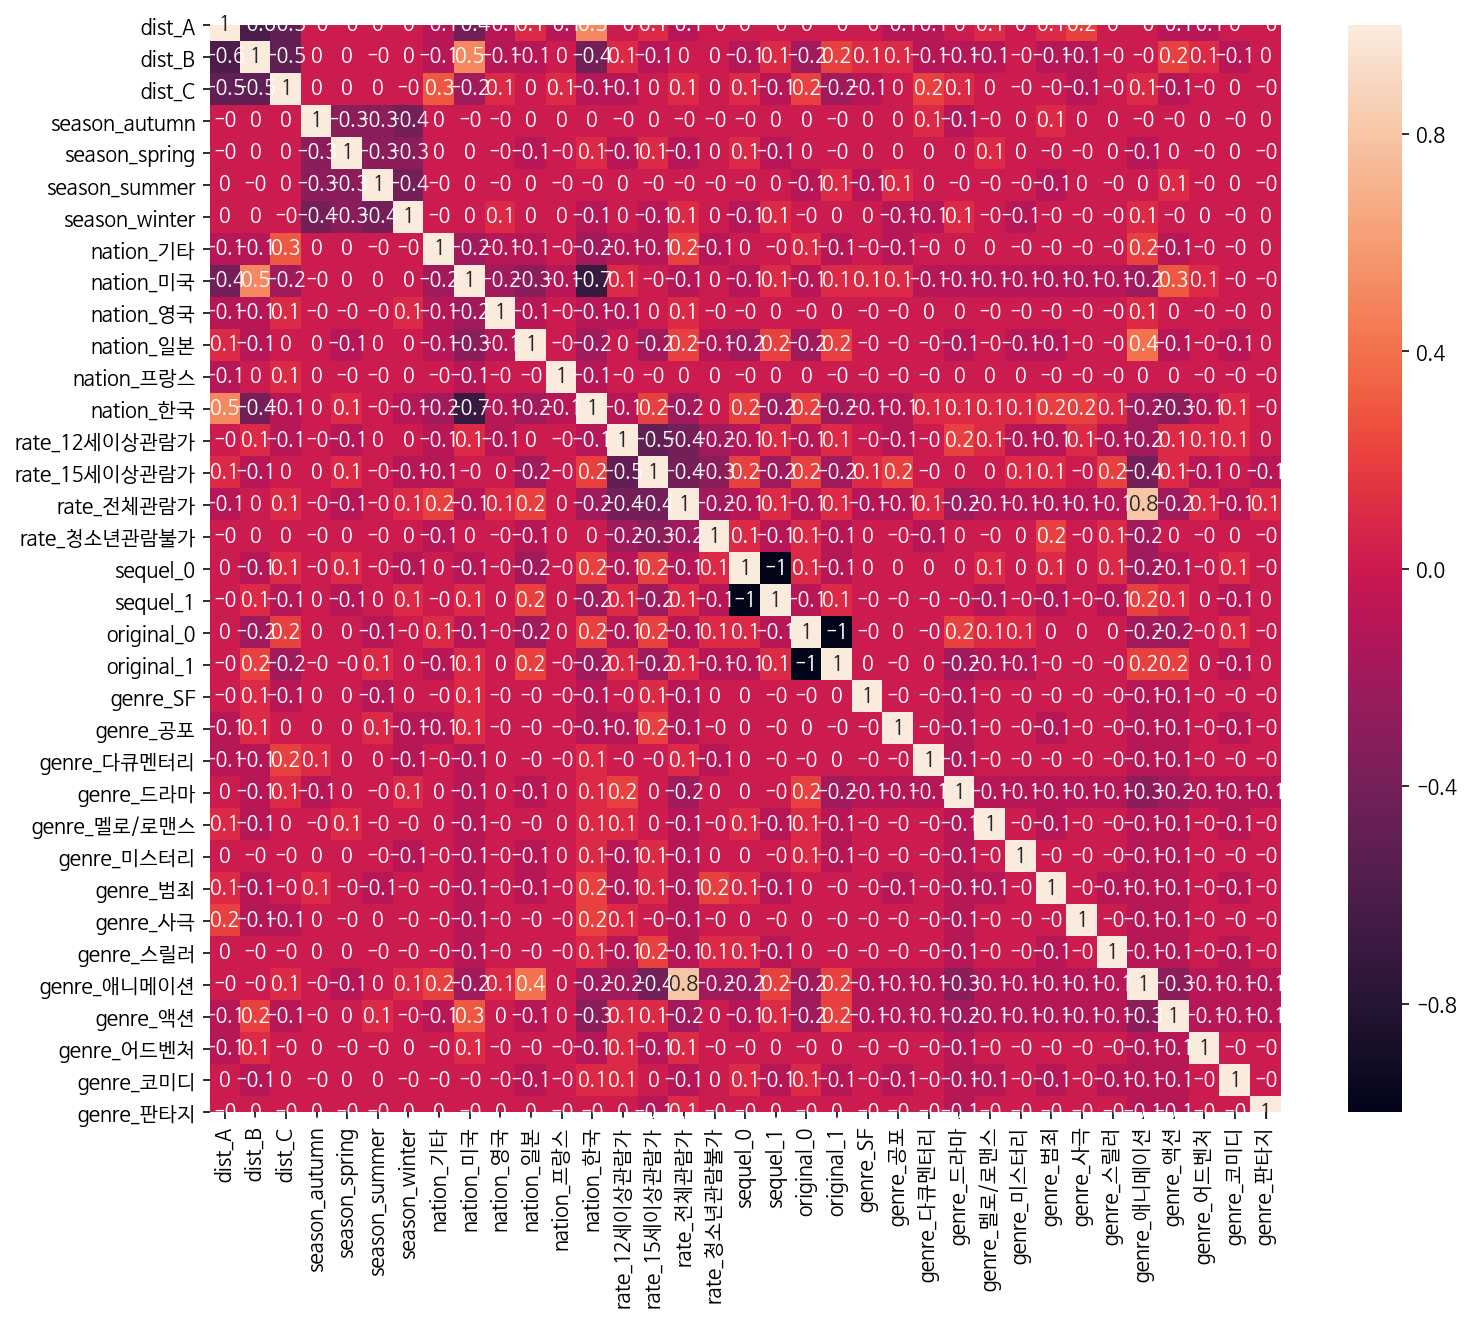

In [142]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=correlation_matrix_cat, annot=True)
plt.show()

### 가설:
#### 배우파워가 관객수에 가장 영향을 많이 줄 것이다
#### 영화의 흥행도는 개봉 후 바이럴마케팅(네이버 기사 수, 네이버 평점, 입소문)의 영향이 크다

### 4. 선형회귀 OLS

#### train-test set 분리 8:2

In [81]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 33 columns):
title                   740 non-null object
director                740 non-null object
distributor             740 non-null object
distributor_group       740 non-null object
release_date            740 non-null int64
release_season          740 non-null object
release                 740 non-null object
form                    740 non-null object
nation                  740 non-null object
screen                  740 non-null int64
rev_nationwide          740 non-null float64
rev_seoul               740 non-null int64
rev_seoul.1             740 non-null int64
genre                   740 non-null object
rate                    740 non-null object
type                    740 non-null object
expert_rating           740 non-null float64
starring_actors         740 non-null object
running_times           740 non-null int64
audience_rating         740 non-null float64
rating_audiences 

In [7]:
kfold_dict = {}
kfold_dict_avr = []
kfold_df = pd.DataFrame()

### modelB : ONLY SCREEN

In [8]:
modelB = sm.OLS.from_formula("log_aud ~ screen", data=df_train_13)
resultB = modelB.fit()
print(resultB.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2008.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):          9.19e-213
Time:                        14:30:05   Log-Likelihood:                -861.39
No. Observations:                 740   AIC:                             1727.
Df Residuals:                     738   BIC:                             1736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9232      0.051    215.914      0.0

In [9]:
# kfold B

from sklearn.model_selection import KFold
ls_olsB = []
kfold_dict['B'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_train_13)):
    df_train = df_train_13.iloc[idx_train]
    df_test = df_train_13.iloc[idx_test]

    modelB = sm.OLS.from_formula(
        "log_aud ~" + "+".join(df_train[["screen"]]), data=df_train)
    resultB = modelB.fit()

    predB = resultB.predict(df_test[['screen']])
    rssB = ((df_test['log_aud'] - predB) ** 2).sum()
    tssB = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquaredB = 1 - rssB/tssB

    scores[i] = rsquaredB
    kfold_dict['B'].append(rsquaredB)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(resultB.rsquared, rsquaredB))
    ls_olsB.append({
        "cv" : i,
        "train_r2" : resultB.rsquared,
        "test_r2" : rsquaredB,
        "model" : resultB
    })

kfold_dict_avr.append(sum(kfold_dict['B'])/10)

학습 R2 = 0.72755167, 검증 R2 = 0.76089254
학습 R2 = 0.72727470, 검증 R2 = 0.75775290
학습 R2 = 0.72663742, 검증 R2 = 0.76016691
학습 R2 = 0.73410966, 검증 R2 = 0.70216915
학습 R2 = 0.72842768, 검증 R2 = 0.75411201
학습 R2 = 0.74051703, 검증 R2 = 0.63585881
학습 R2 = 0.73279631, 검증 R2 = 0.70509477
학습 R2 = 0.73361713, 검증 R2 = 0.70327641
학습 R2 = 0.72556804, 검증 R2 = 0.78707561
학습 R2 = 0.73725813, 검증 R2 = 0.68764684


In [10]:
df_olsB = pd.DataFrame(ls_olsB)
df_olsB

cv  train_r2   test_r2                                              model
0   0  0.727552  0.760893  <statsmodels.regression.linear_model.Regressio...
1   1  0.727275  0.757753  <statsmodels.regression.linear_model.Regressio...
2   2  0.726637  0.760167  <statsmodels.regression.linear_model.Regressio...
3   3  0.734110  0.702169  <statsmodels.regression.linear_model.Regressio...
4   4  0.728428  0.754112  <statsmodels.regression.linear_model.Regressio...
5   5  0.740517  0.635859  <statsmodels.regression.linear_model.Regressio...
6   6  0.732796  0.705095  <statsmodels.regression.linear_model.Regressio...
7   7  0.733617  0.703276  <statsmodels.regression.linear_model.Regressio...
8   8  0.725568  0.787076  <statsmodels.regression.linear_model.Regressio...
9   9  0.737258  0.687647  <statsmodels.regression.linear_model.Regressio...

In [11]:
np.average(kfold_dict['B'])

0.7254045960138017

In [12]:
predB =  resultB.predict(X_test[["screen"]])
rssB = ((y_test.log_aud - predB) ** 2).sum()
tssB = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredB = 1 - rssB/tssB
rsquaredB

0.7284602705058647

In [13]:
df = df_train_13 

# model0
- 아무 처리 안한 원본
- 16개의 독립변수 모두 사용

In [8]:
df0 = df.copy()

In [9]:
sm.stats.anova_lm(result0)

NameError: name 'result0' is not defined

In [10]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)', 'C(holiday)']
model0 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df_train_13)
result0 = model0.fit()
print(result0.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     54.34
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          9.51e-182
Time:                        10:27:46   Log-Likelihood:                -11288.
No. Observations:                 740   AIC:                         2.265e+04
Df Residuals:                     701   BIC:                         2.283e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [19]:
# kfold 0

from sklearn.model_selection import KFold

kfold_dict['0'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df0)):
    df_train = df0.iloc[idx_train]
    df_test = df0.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original', 'holiday']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['0'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['0'])/10)

학습 R2 = 0.78571897, 검증 R2 = 0.78952106
학습 R2 = 0.78880715, 검증 R2 = 0.75108473
학습 R2 = 0.78400663, 검증 R2 = 0.71770229
학습 R2 = 0.79299398, 검증 R2 = 0.72312188
학습 R2 = 0.78706335, 검증 R2 = 0.77818554
학습 R2 = 0.79041300, 검증 R2 = 0.73927071
학습 R2 = 0.79204625, 검증 R2 = 0.71261928
학습 R2 = 0.79076455, 검증 R2 = 0.74148381
학습 R2 = 0.78677045, 검증 R2 = 0.77739983
학습 R2 = 0.79206514, 검증 R2 = 0.73423339


In [12]:
# model0의 테스트 R

pred = result0.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original', 'holiday']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

-1694884170882.6885

# model1
- 종속변수에 log 

In [13]:
df1 = df0.copy()

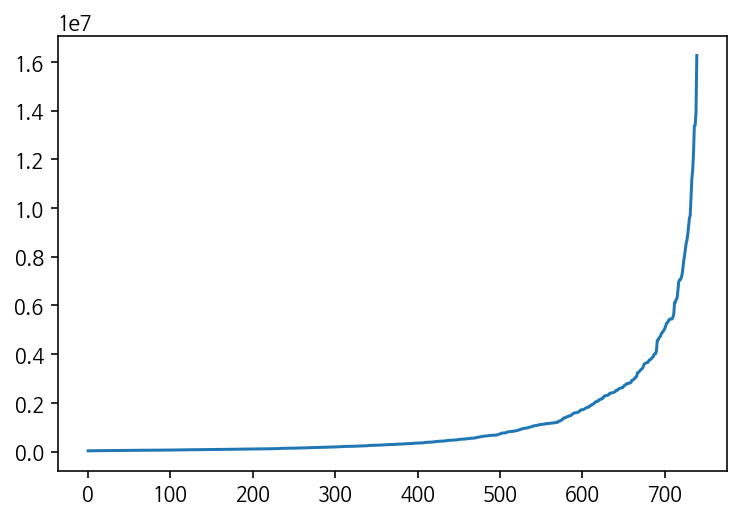

In [23]:
plt.plot(df1['aud_nationwide'].sort_values().reset_index(drop=True))

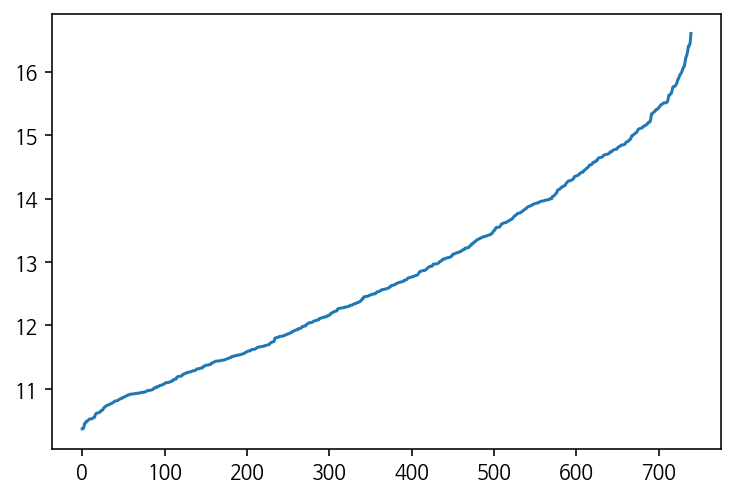

In [24]:
plt.plot(np.log(df1['aud_nationwide'].sort_values().reset_index(drop=True)))

In [25]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)', 'C(holiday)']
model1 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     68.34
Date:                Sat, 11 Apr 2020   Prob (F-statistic):          4.21e-208
Time:                        14:31:02   Log-Likelihood:                -774.60
No. Observations:                 740   AIC:                             1627.
Df Residuals:                     701   BIC:                             1807.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [26]:
# kfold 1

from sklearn.model_selection import KFold

kfold_dict['1'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original', 'holiday']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['1'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['1'])/10)


학습 R2 = 0.78571897, 검증 R2 = 0.78952106
학습 R2 = 0.78880715, 검증 R2 = 0.75108473
학습 R2 = 0.78400663, 검증 R2 = 0.71770229
학습 R2 = 0.79299398, 검증 R2 = 0.72312188
학습 R2 = 0.78706335, 검증 R2 = 0.77818554
학습 R2 = 0.79041300, 검증 R2 = 0.73927071
학습 R2 = 0.79204625, 검증 R2 = 0.71261928
학습 R2 = 0.79076455, 검증 R2 = 0.74148381
학습 R2 = 0.78677045, 검증 R2 = 0.77739983
학습 R2 = 0.79206514, 검증 R2 = 0.73423339


In [27]:
# model1의 테스트 R

pred = result1.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original', 'holiday']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7443569280673333

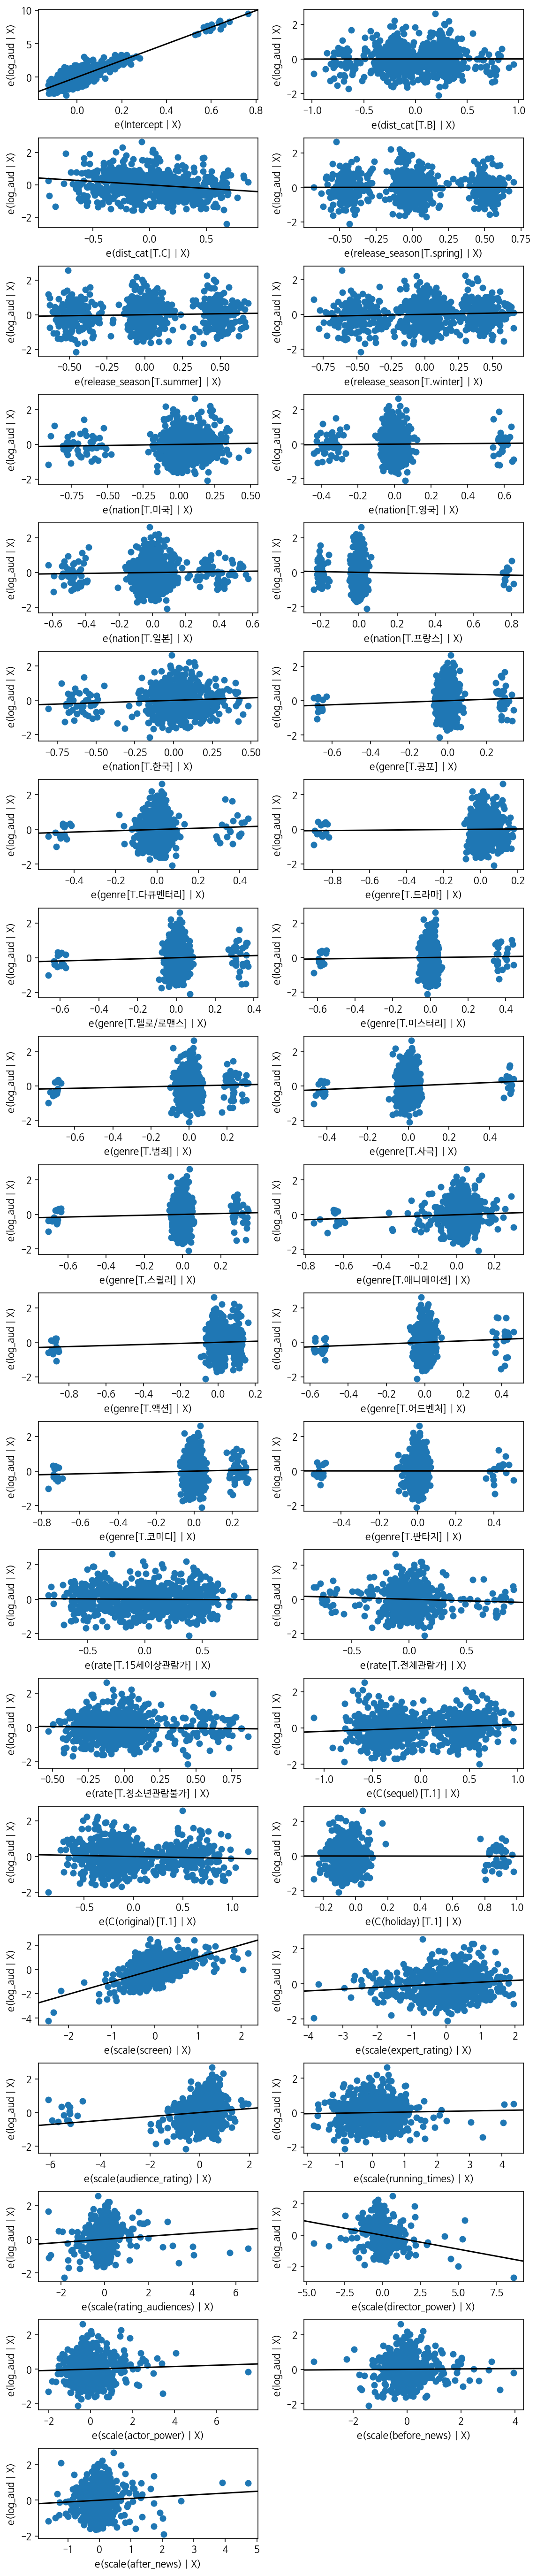

In [28]:
fig = plt.figure(figsize=(8, 40))
sm.graphics.plot_partregress_grid(result1, fig=fig)
fig.suptitle("")
plt.show()

In [29]:
df_final_13_features = ['actor_power', 'after_news', 'aud_nationwide', 'audience_rating', 'before_news', 'director_power', 'dist_cat',
 'distributor_group', 'expert_rating', 'genre', 'holiday', 'log_aud', 'nation', 'original', 'rate', 'rating_audiences', 'realease_year',
 'release_season', 'running_times', 'screen', 'sequel']

In [48]:
list(set(df.columns))

['after_news',
 'starring_actors',
 'rev_nationwide',
 'form',
 'before_news',
 'release_season',
 'actor_movie_count',
 'log_aud',
 'release_date',
 'distributor',
 'actor_power',
 'audience_rating',
 'director_movie_count',
 'aud_nationwide',
 'sequel',
 'running_times',
 'director_count',
 'distributor_group',
 'director',
 'rating_audiences',
 'screen',
 'holiday',
 'title',
 'genre',
 'rate',
 'original',
 'dist_cat',
 'rev_seoul.1',
 'release',
 'director_power',
 'type',
 'realease_year',
 'expert_rating',
 'nation',
 'rev_seoul']

In [49]:
list(set(df_final_13_features).difference(set(["log_aud", "before_news"])))

['after_news',
 'aud_nationwide',
 'sequel',
 'running_times',
 'distributor_group',
 'rating_audiences',
 'screen',
 'holiday',
 'release_season',
 'genre',
 'actor_power',
 'rate',
 'dist_cat',
 'original',
 'audience_rating',
 'director_power',
 'realease_year',
 'expert_rating',
 'nation']

In [30]:
dfdf = df0[['original',
 'rate',
 'screen',
 'after_news', 'before_news',
 'director_power',
 'dist_cat',
 'actor_power',
 'realease_year',
 'aud_nationwide',
 'release_season',
 'audience_rating',
 'rating_audiences',
 'distributor_group',
 'running_times',
 'genre',
 'sequel',
 'expert_rating',
 'nation',
 'holiday', 'log_aud']]

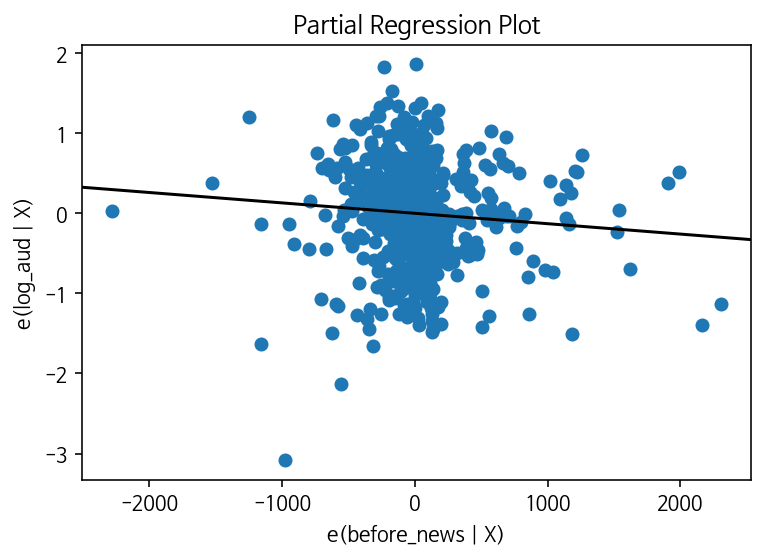

In [51]:
others = list(set(df_final_13_features).difference(set(["log_aud", "before_news"])))
p, resids = sm.graphics.plot_partregress("log_aud", "before_news", others, data=dfdf, obs_labels=False, ret_coords=True)
plt.show()

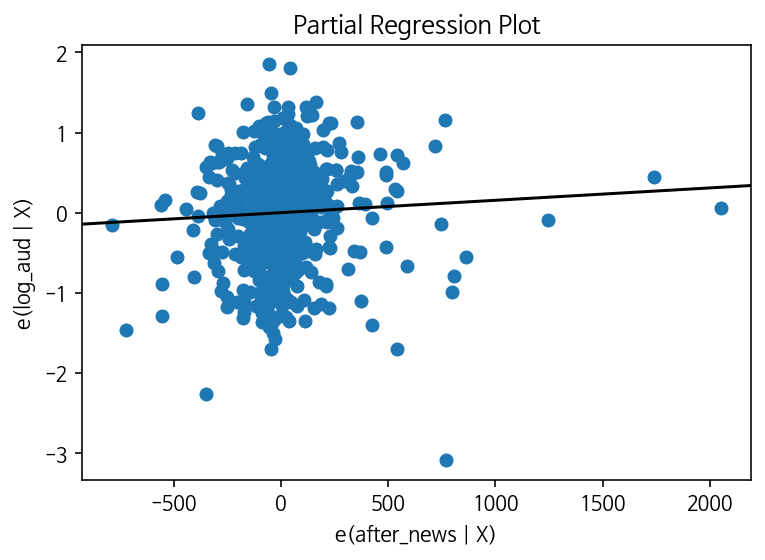

In [52]:
others = list(set(df_final_13_features).difference(set(["log_aud", "after_news"])))
p, resids = sm.graphics.plot_partregress("log_aud", "after_news", others, data=dfdf, obs_labels=False, ret_coords=True)
plt.show()


# model2
- 뉴스기사 컬럼에 대한 처리

In [14]:
df2 = df1.copy()

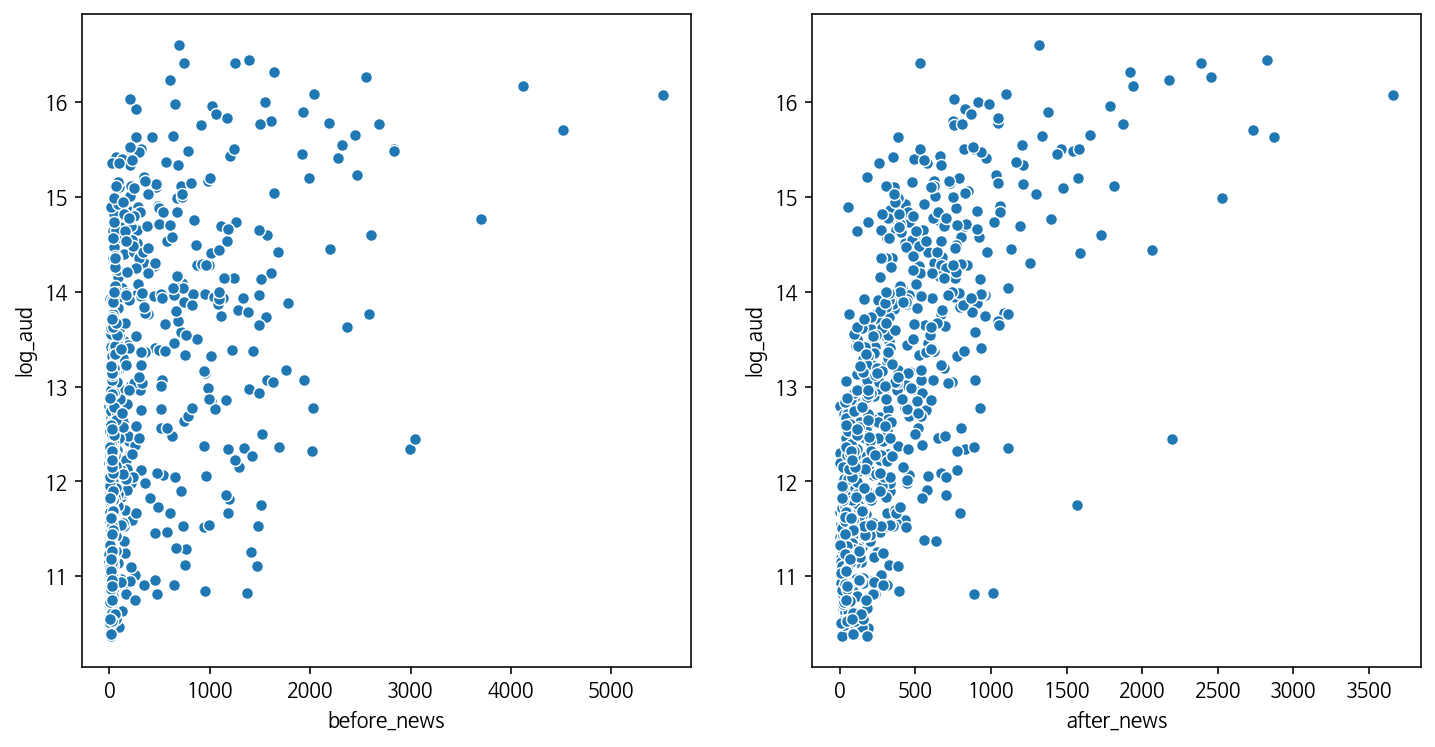

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="log_aud", data=df2)
plt.subplot(122)
sns.scatterplot(x="after_news", y="log_aud", data=df2)
plt.show()

In [15]:
df2_1 = df2.copy()

In [34]:
# 로그 취한값에 다시 루트 씌우기

df2_1['log_sqrt_before_news'] = df2_1['before_news'].apply(
    lambda news: np.log(news))
df2_1['log_sqrt_after_news'] = df2_1['after_news'].apply(
    lambda news: np.log(news))

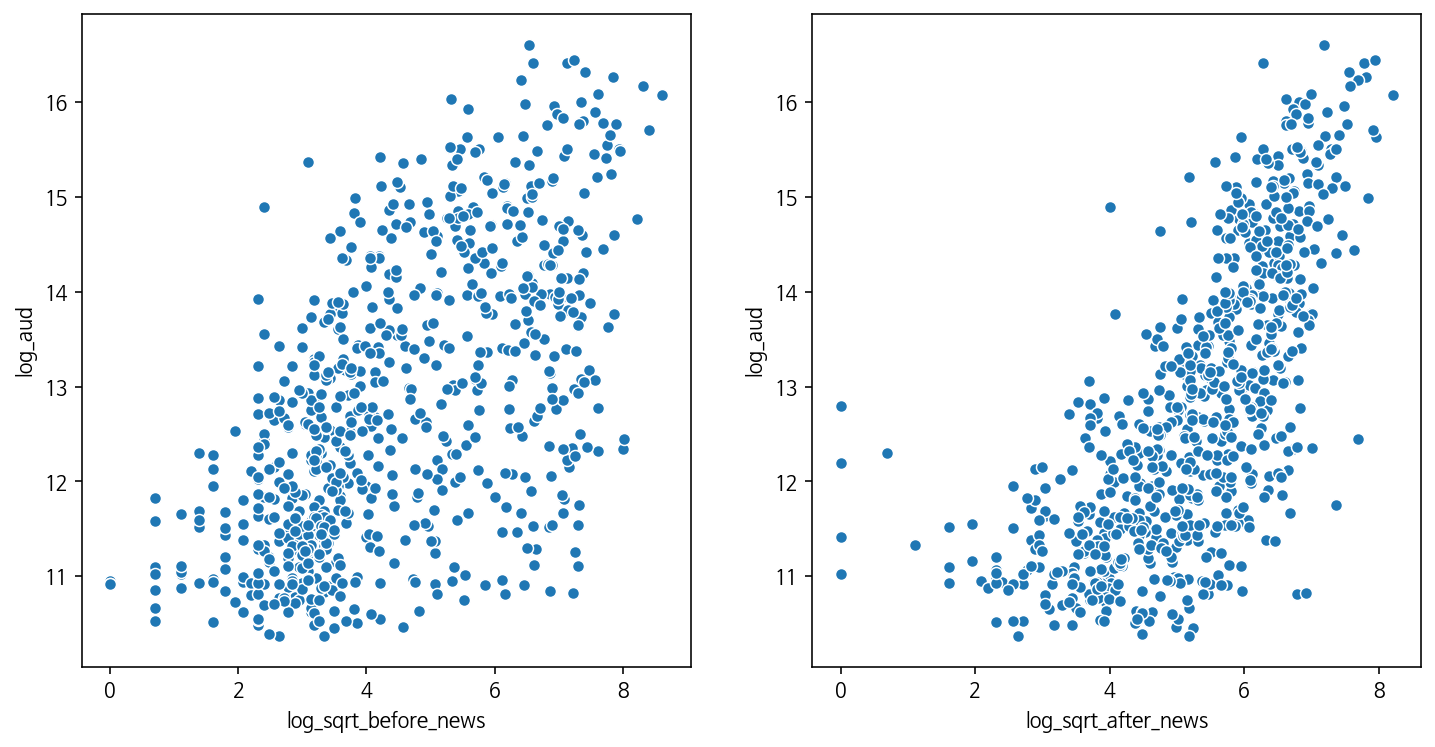

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_sqrt_before_news", y="log_aud", data=df2_1)
plt.subplot(122)
sns.scatterplot(x="log_sqrt_after_news", y="log_aud", data=df2_1)
plt.show()

In [16]:
df2['after_news_0to1'] = df2['after_news'].apply(lambda num: num if num > 0 else 1.0)
df2['before_news_0to1'] = df2['before_news'].apply(lambda num: num if num > 0 else 1.0)

In [17]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences',
                 'director_power', 'actor_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)', 'C(holiday)']
model2 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     88.70
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          1.62e-272
Time:                        10:28:50   Log-Likelihood:                -961.57
No. Observations:                 925   AIC:                             2001.
Df Residuals:                     886   BIC:                             2189.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [38]:
dfdfdf = df2[['original',
 'rate',
 'screen',
 'after_news', 'after_news_0to1', 'before_news', "before_news_0to1",
 'director_power',
 'dist_cat',
 'actor_power',
 'realease_year',
 'aud_nationwide',
 'release_season',
 'audience_rating',
 'rating_audiences',
 'distributor_group',
 'running_times',
 'genre',
 'sequel',
 'expert_rating',
 'nation',
 'holiday', 'log_aud']]

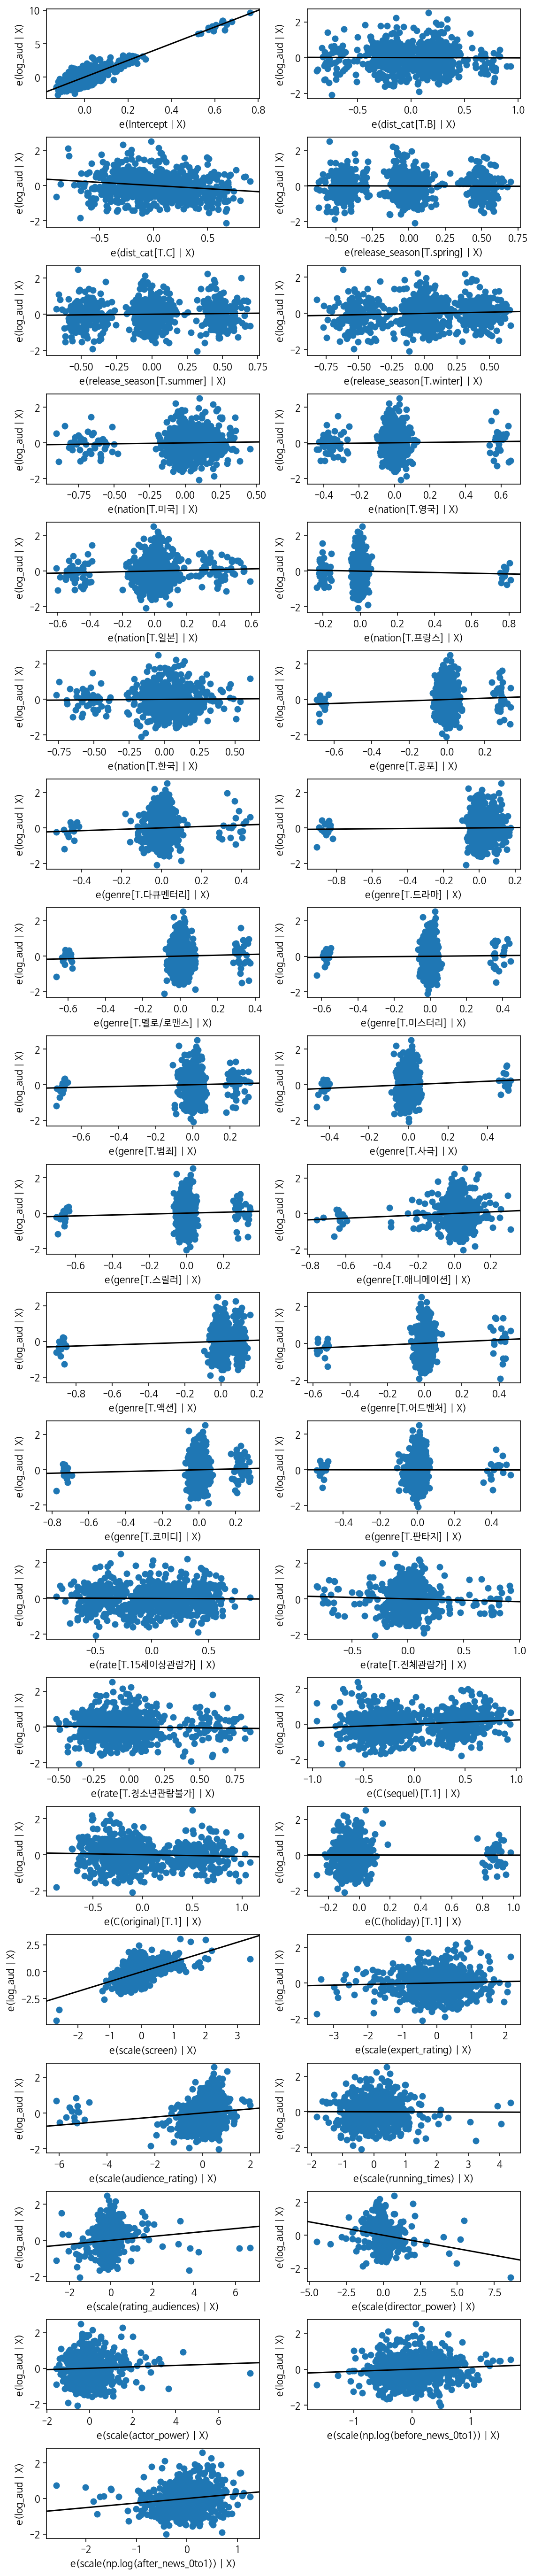

In [39]:
fig = plt.figure(figsize=(8, 40))
sm.graphics.plot_partregress_grid(result2, fig=fig)
fig.suptitle("")
plt.show()

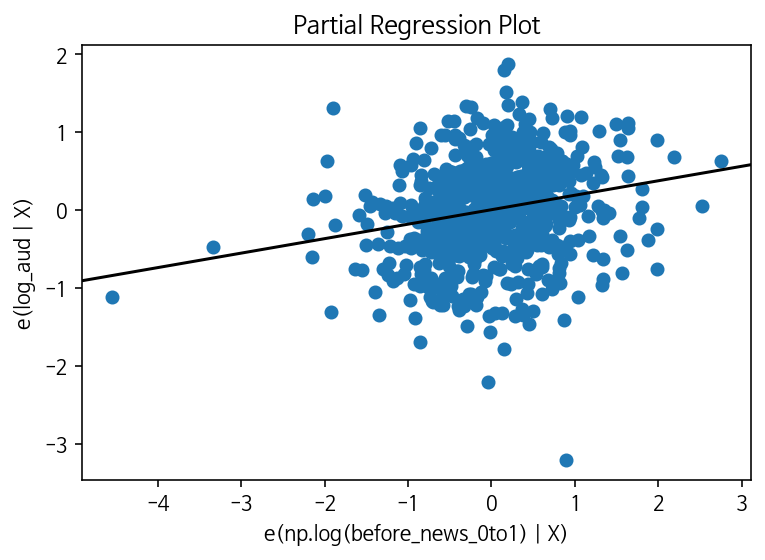

In [63]:
others = list(set(dfdfdf).difference(set(["log_aud", "np.log(before_news_0to1)"])))
p, resids = sm.graphics.plot_partregress("log_aud", "np.log(before_news_0to1)", others, data=dfdfdf, obs_labels=False, ret_coords=True)
plt.show()

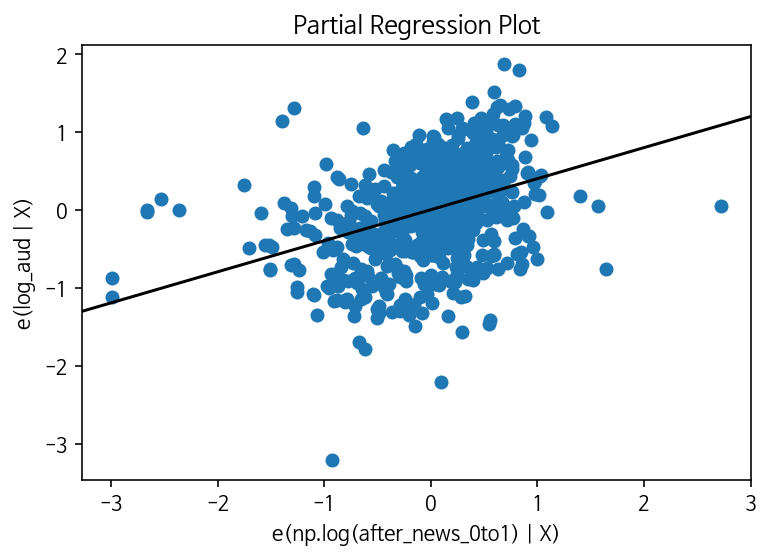

In [64]:
others = list(set(dfdfdf).difference(set(["log_aud", "np.log(after_news_0to1)"])))
p, resids = sm.graphics.plot_partregress("log_aud", "np.log(after_news_0to1)", others, data=dfdfdf, obs_labels=False, ret_coords=True)
plt.show()


In [18]:
X_test['after_news_0to1'] = X_test['after_news'].apply(
    lambda num: num if num > 0 else 1.0)
X_test['before_news_0to1'] = X_test['before_news'].apply(
    lambda num: num if num > 0 else 1.0)

In [19]:
# kfold 2

from sklearn.model_selection import KFold

kfold_dict['2'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news_0to1', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original', 'holiday']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['2'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['2'])/10)


NameError: name 'kfold_dict' is not defined

In [42]:
np.average(kfold_dict['2'])

0.7589427370289006

In [227]:
#X_test["after_news_0to1"] = np.exp(X_test["after_news_0to1"])
#X_test["before_news_0to1"] = np.exp(X_test["before_news_0to1"])

In [20]:
# model2의 테스트 Rsqured

pred = result2.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news_0to1', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original', 'holiday']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7694939779285838

In [265]:
sm.stats.anova_lm(result2)

df      sum_sq     mean_sq            F  \
dist_cat                           2.0  520.925690  260.462845   532.829117   
release_season                     3.0   11.127962    3.709321     7.588161   
nation                             5.0  143.506307   28.701261    58.714201   
genre                             13.0  113.710190    8.746938    17.893620   
rate                               3.0   52.213500   17.404500    35.604404   
C(sequel)                          1.0    5.508749    5.508749    11.269253   
C(original)                        1.0    8.799339    8.799339    18.000816   
C(holiday)                         1.0    1.193403    1.193403     2.441346   
scale(screen)                      1.0  731.487561  731.487561  1496.404877   
scale(expert_rating)               1.0    9.653836    9.653836    19.748862   
scale(audience_rating)             1.0    8.443707    8.443707    17.273300   
scale(running_times)               1.0    0.087299    0.087299     0.178588   
scale(rating_audiences)            1.0    1.218968    1.218968     2.493644   
scale(director_power)              1.0   13.877801   13.877801    28.389832   
scale(actor_power)                 1.0    0.581828    0.581828     1.190246   
scale(np.log(before_news_0to1))    1.0   13.974433   13.974433    28.587513   
scale(np.log(after_news_0to1))     1.0   11.388539   11.388539    23.297547   
Residual                         886.0  433.103359    0.488830          NaN   

                                        PR(>F)  
dist_cat                         1.159496e-152  
release_season                    5.158678e-05  
nation                            7.683807e-53  
genre                             3.390683e-37  
rate                              9.924752e-22  
C(sequel)                         8.215624e-04  
C(original)                       2.440510e-05  
C(holiday)                        1.185319e-01  
scale(screen)                    1.675083e-192  
scale(expert_rating)              9.950085e-06  
scale(audience_rating)            3.551009e-05  
scale(running_times)              6.726919e-01  
scale(rating_audiences)           1.146637e-01  
scale(director_power)             1.258655e-07  
scale(actor_power)                2.755765e-01  
scale(np.log(before_news_0to1))   1.140115e-07  
scale(np.log(after_news_0to1))    1.633927e-06  
Residual                                   NaN

# model3
- 아웃라이어 3개 제거
- 576 어벤져스: 엔드게임
- 398 캡틴 아메리카: 시빌 워
- 361 어벤져스: 인피니티 워

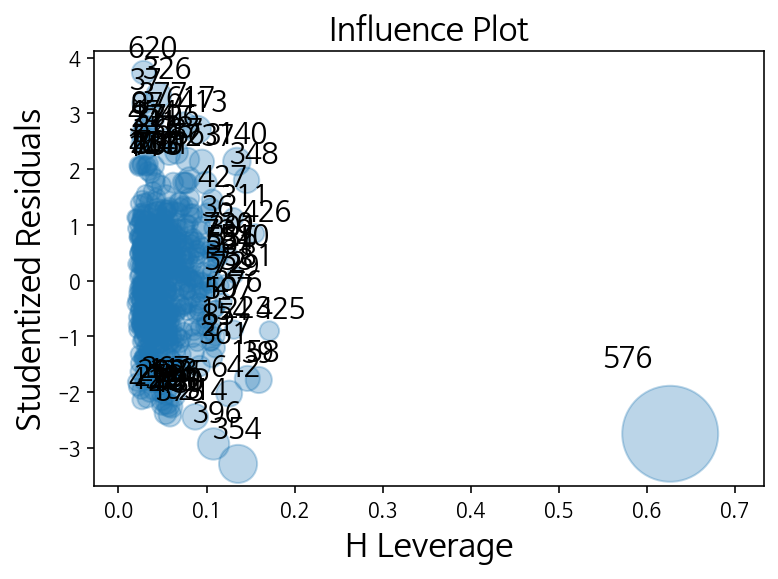

In [44]:
# Cook's distance

sm.graphics.influence_plot(result2, plot_alpha=0.3)
plt.show()

In [21]:
df3 = df2.copy()

In [46]:
df3 = df3.drop(index=[576])

In [47]:
df3[df3["after_news_0to1"] == 0]

Empty DataFrame
Columns: [title, director, distributor, distributor_group, release_date, release_season, release, form, nation, screen, rev_nationwide, rev_seoul, rev_seoul.1, genre, rate, type, expert_rating, starring_actors, running_times, audience_rating, rating_audiences, realease_year, director_power, sequel, original, actor_power, director_count, director_movie_count, actor_movie_count, before_news, after_news, holiday, dist_cat, aud_nationwide, log_aud, after_news_0to1, before_news_0to1]
Index: []

[0 rows x 37 columns]

In [ ]:
#df3['after_news_0to1'] = df3['after_news'].apply(lambda num: num if num > 0 else 1.0)
#df3['before_news_0to1'] = df3['before_news'].apply(lambda num: num if num > 0 else 1.0)

In [22]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences',
                 'director_power', 'actor_power', 'np.log(before_news_0to1)', 'np.log(after_news_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model3 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     91.05
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          3.05e-273
Time:                        10:29:36   Log-Likelihood:                -962.19
No. Observations:                 925   AIC:                             2000.
Df Residuals:                     887   BIC:                             2184.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [49]:
# kfold 3

from sklearn.model_selection import KFold

kfold_dict['3'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'before_news_0to1', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['3'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['3'])/10)


학습 R2 = 0.79647974, 검증 R2 = 0.81831811
학습 R2 = 0.80227830, 검증 R2 = 0.75876720
학습 R2 = 0.79394941, 검증 R2 = 0.82304223
학습 R2 = 0.80307250, 검증 R2 = 0.74771521
학습 R2 = 0.80170613, 검증 R2 = 0.77335302
학습 R2 = 0.80328309, 검증 R2 = 0.74721400
학습 R2 = 0.80712389, 검증 R2 = 0.65998571
학습 R2 = 0.80376226, 검증 R2 = 0.75258952
학습 R2 = 0.80058224, 검증 R2 = 0.77830303
학습 R2 = 0.80175784, 검증 R2 = 0.77368113


In [23]:
# model3의 테스트 R

pred = result3.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news_0to1', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7669574824732327

In [24]:
df4 = df3.copy()

In [25]:
df5 = df4.copy()

### modelC
- screen
- log(after_news_0to1)

In [26]:
feature_namesC = ['screen']
feature_namesC = ["scale({})".format(name) for name in feature_namesC] + ['dist_cat']

modelD = sm.OLS.from_formula("log_aud ~ screen + dist_cat", data=df3)
modelC = sm.OLS.from_formula("log_aud ~ scale(screen) + scale(np.log(after_news_0to1))", data=df3)
resultC = modelC.fit()
print(resultC.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1411.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          2.65e-281
Time:                        10:29:50   Log-Likelihood:                -1039.3
No. Observations:                 925   AIC:                             2085.
Df Residuals:                     922   BIC:                             2099.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [63]:
# kfold C

from sklearn.model_selection import KFold
ls_olsC = []
kfold_dict['C'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    modelC = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_namesC), data=df_train)
    resultC = modelC.fit()

    predC = resultC.predict(df_test[['screen', 'after_news_0to1', 'dist_cat']])
    rssC = ((df_test['log_aud'] - predC) ** 2).sum()
    tssC = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquaredC = 1 - rssC/tssC

    scores[i] = rsquaredC
    kfold_dict['C'].append(rsquaredC)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(resultC.rsquared, rsquaredC))
    ls_olsC.append({
        "cv" : i,
        "train_r2" : resultC.rsquared,
        "test_r2" : rsquaredC,
        "model" : resultC
    })

kfold_dict_avr.append(sum(kfold_dict['C'])/10)

학습 R2 = 0.74697371, 검증 R2 = 0.77108257
학습 R2 = 0.75026586, 검증 R2 = 0.73603744
학습 R2 = 0.73794036, 검증 R2 = 0.83924421
학습 R2 = 0.75703391, 검증 R2 = 0.66827121
학습 R2 = 0.74893029, 검증 R2 = 0.75694021
학습 R2 = 0.75478753, 검증 R2 = 0.69564409
학습 R2 = 0.75262758, 검증 R2 = 0.68255930
학습 R2 = 0.75319551, 검증 R2 = 0.71425773
학습 R2 = 0.74571636, 검증 R2 = 0.78898347
학습 R2 = 0.75285327, 검증 R2 = 0.72649668


In [64]:
df_olsC = pd.DataFrame(ls_olsC)
df_olsC

cv  train_r2   test_r2                                              model
0   0  0.746974  0.771083  <statsmodels.regression.linear_model.Regressio...
1   1  0.750266  0.736037  <statsmodels.regression.linear_model.Regressio...
2   2  0.737940  0.839244  <statsmodels.regression.linear_model.Regressio...
3   3  0.757034  0.668271  <statsmodels.regression.linear_model.Regressio...
4   4  0.748930  0.756940  <statsmodels.regression.linear_model.Regressio...
5   5  0.754788  0.695644  <statsmodels.regression.linear_model.Regressio...
6   6  0.752628  0.682559  <statsmodels.regression.linear_model.Regressio...
7   7  0.753196  0.714258  <statsmodels.regression.linear_model.Regressio...
8   8  0.745716  0.788983  <statsmodels.regression.linear_model.Regressio...
9   9  0.752853  0.726497  <statsmodels.regression.linear_model.Regressio...

In [27]:
np.average(kfold_dict['C'])

NameError: name 'kfold_dict' is not defined

In [28]:
predC =  resultC.predict(X_test[["screen", "after_news_0to1", "dist_cat"]])
rssC = ((y_test.log_aud - predC) ** 2).sum()
tssC = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredC = 1 - rssC/tssC
rsquaredC

0.7402428384787672

In [68]:
sm.stats.anova_lm(resultC)

df      sum_sq     mean_sq            F         PR(>F)
dist_cat         2.0  368.866252  184.433126   343.626368  4.396528e-103
scale(screen)    1.0  713.479231  713.479231  1329.318015  1.850232e-160
Residual       662.0  355.312458    0.536726          NaN            NaN

### modelD
- screen
- dist_cat

In [29]:
feature_namesD = ['screen']
feature_namesD = ["scale({})".format(name) for name in feature_namesD] + ['dist_cat']
modelD = sm.OLS.from_formula("log_aud ~ screen + dist_cat", data=df3)
resultD = modelD.fit()
print(resultD.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     902.9
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          1.10e-273
Time:                        10:30:02   Log-Likelihood:                -1053.2
No. Observations:                 925   AIC:                             2114.
Df Residuals:                     921   BIC:                             2134.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.2192      0.066    170.517

In [70]:
# kfold D

from sklearn.model_selection import KFold
ls_olsD = []
kfold_dict['D'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    modelD = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_namesD), data=df_train)
    resultD = modelD.fit()

    predD = resultD.predict(df_test[['screen', 'dist_cat']])
    rssD = ((df_test['log_aud'] - predD) ** 2).sum()
    tssD = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquaredD = 1 - rssD/tssD

    scores[i] = rsquaredD
    kfold_dict['D'].append(rsquaredD)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(resultD.rsquared, rsquaredD))
    ls_olsD.append({
        "cv" : i,
        "train_r2" : resultD.rsquared,
        "test_r2" : rsquaredD,
        "model" : resultD
    })

kfold_dict_avr.append(sum(kfold_dict['D'])/10)

학습 R2 = 0.74697371, 검증 R2 = 0.77108257
학습 R2 = 0.75026586, 검증 R2 = 0.73603744
학습 R2 = 0.73794036, 검증 R2 = 0.83924421
학습 R2 = 0.75703391, 검증 R2 = 0.66827121
학습 R2 = 0.74893029, 검증 R2 = 0.75694021
학습 R2 = 0.75478753, 검증 R2 = 0.69564409
학습 R2 = 0.75262758, 검증 R2 = 0.68255930
학습 R2 = 0.75319551, 검증 R2 = 0.71425773
학습 R2 = 0.74571636, 검증 R2 = 0.78898347
학습 R2 = 0.75285327, 검증 R2 = 0.72649668


In [71]:
df_olsD = pd.DataFrame(ls_olsD)
df_olsD

cv  train_r2   test_r2                                              model
0   0  0.746974  0.771083  <statsmodels.regression.linear_model.Regressio...
1   1  0.750266  0.736037  <statsmodels.regression.linear_model.Regressio...
2   2  0.737940  0.839244  <statsmodels.regression.linear_model.Regressio...
3   3  0.757034  0.668271  <statsmodels.regression.linear_model.Regressio...
4   4  0.748930  0.756940  <statsmodels.regression.linear_model.Regressio...
5   5  0.754788  0.695644  <statsmodels.regression.linear_model.Regressio...
6   6  0.752628  0.682559  <statsmodels.regression.linear_model.Regressio...
7   7  0.753196  0.714258  <statsmodels.regression.linear_model.Regressio...
8   8  0.745716  0.788983  <statsmodels.regression.linear_model.Regressio...
9   9  0.752853  0.726497  <statsmodels.regression.linear_model.Regressio...

In [72]:
np.average(kfold_dict['D'])

0.7379516904815325

In [30]:
predD =  resultD.predict(X_test[["screen", "dist_cat"]])
rssD = ((y_test.log_aud - predD) ** 2).sum()
tssD = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredD = 1 - rssD/tssD
rsquaredD

0.7420032967199806

In [74]:
sm.stats.anova_lm(resultD)

df      sum_sq     mean_sq            F         PR(>F)
dist_cat         2.0  368.866252  184.433126   343.626368  4.396528e-103
scale(screen)    1.0  713.479231  713.479231  1329.318015  1.850232e-160
Residual       662.0  355.312458    0.536726          NaN            NaN

### modelF

In [31]:
feature_namesF = ['screen', 'after_news_0to1']
feature_namesF = ["scale({})".format(name) for name in feature_namesF] + ['dist_cat']
modelF = sm.OLS.from_formula("log_aud ~ scale(screen) + dist_cat + scale(np.log(after_news_0to1))", data=df3)
resultF = modelF.fit()
print(resultF.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     743.6
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          1.89e-286
Time:                        10:30:13   Log-Likelihood:                -1020.1
No. Observations:                 925   AIC:                             2050.
Df Residuals:                     920   BIC:                             2074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [76]:
# kfold F

from sklearn.model_selection import KFold
ls_olsF = []
kfold_dict['F'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    modelF = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_namesF), data=df_train)
    resultF = modelF.fit()

    predF = resultF.predict(df_test[['screen', 'dist_cat', 'after_news_0to1']])
    rssF = ((df_test['log_aud'] - predF) ** 2).sum()
    tssF = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquaredF = 1 - rssF/tssF

    scores[i] = rsquaredF
    kfold_dict['F'].append(rsquaredF)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(resultF.rsquared, rsquaredF))
    ls_olsF.append({
        "cv" : i,
        "train_r2" : resultF.rsquared,
        "test_r2" : rsquaredF,
        "model" : resultF
    })

kfold_dict_avr.append(sum(kfold_dict['F'])/10)

학습 R2 = 0.75010192, 검증 R2 = 0.78767338
학습 R2 = 0.75725643, 검증 R2 = 0.71896943
학습 R2 = 0.74272142, 검증 R2 = 0.84492119
학습 R2 = 0.76104981, 검증 R2 = 0.68124823
학습 R2 = 0.75361202, 검증 R2 = 0.76369378
학습 R2 = 0.76141020, 검증 R2 = 0.68211603
학습 R2 = 0.75711106, 검증 R2 = 0.69329485
학습 R2 = 0.75757842, 검증 R2 = 0.72363446
학습 R2 = 0.75146475, 검증 R2 = 0.78491250
학습 R2 = 0.75748887, 검증 R2 = 0.73307454


In [77]:
df_olsF = pd.DataFrame(ls_olsF)
df_olsF

cv  train_r2   test_r2                                              model
0   0  0.750102  0.787673  <statsmodels.regression.linear_model.Regressio...
1   1  0.757256  0.718969  <statsmodels.regression.linear_model.Regressio...
2   2  0.742721  0.844921  <statsmodels.regression.linear_model.Regressio...
3   3  0.761050  0.681248  <statsmodels.regression.linear_model.Regressio...
4   4  0.753612  0.763694  <statsmodels.regression.linear_model.Regressio...
5   5  0.761410  0.682116  <statsmodels.regression.linear_model.Regressio...
6   6  0.757111  0.693295  <statsmodels.regression.linear_model.Regressio...
7   7  0.757578  0.723634  <statsmodels.regression.linear_model.Regressio...
8   8  0.751465  0.784913  <statsmodels.regression.linear_model.Regressio...
9   9  0.757489  0.733075  <statsmodels.regression.linear_model.Regressio...

In [78]:
np.average(kfold_dict['F'])

0.7413538366992662

In [32]:
predF =  resultF.predict(X_test[["screen", "dist_cat", 'after_news_0to1']])
rssF = ((y_test.log_aud - predF) ** 2).sum()
tssF = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredF = 1 - rssF/tssF
rsquaredF

0.7496925068039669

In [80]:
sm.stats.anova_lm(resultF)

df      sum_sq     mean_sq            F  \
dist_cat                  2.0  368.866252  184.433126   349.665783   
scale(screen)             1.0  713.479231  713.479231  1352.681480   
scale(after_news_0to1)    1.0    6.664399    6.664399    12.634999   
Residual                661.0  348.648059    0.527455          NaN   

                               PR(>F)  
dist_cat                2.552608e-104  
scale(screen)           4.846008e-162  
scale(after_news_0to1)   4.055801e-04  
Residual                          NaN

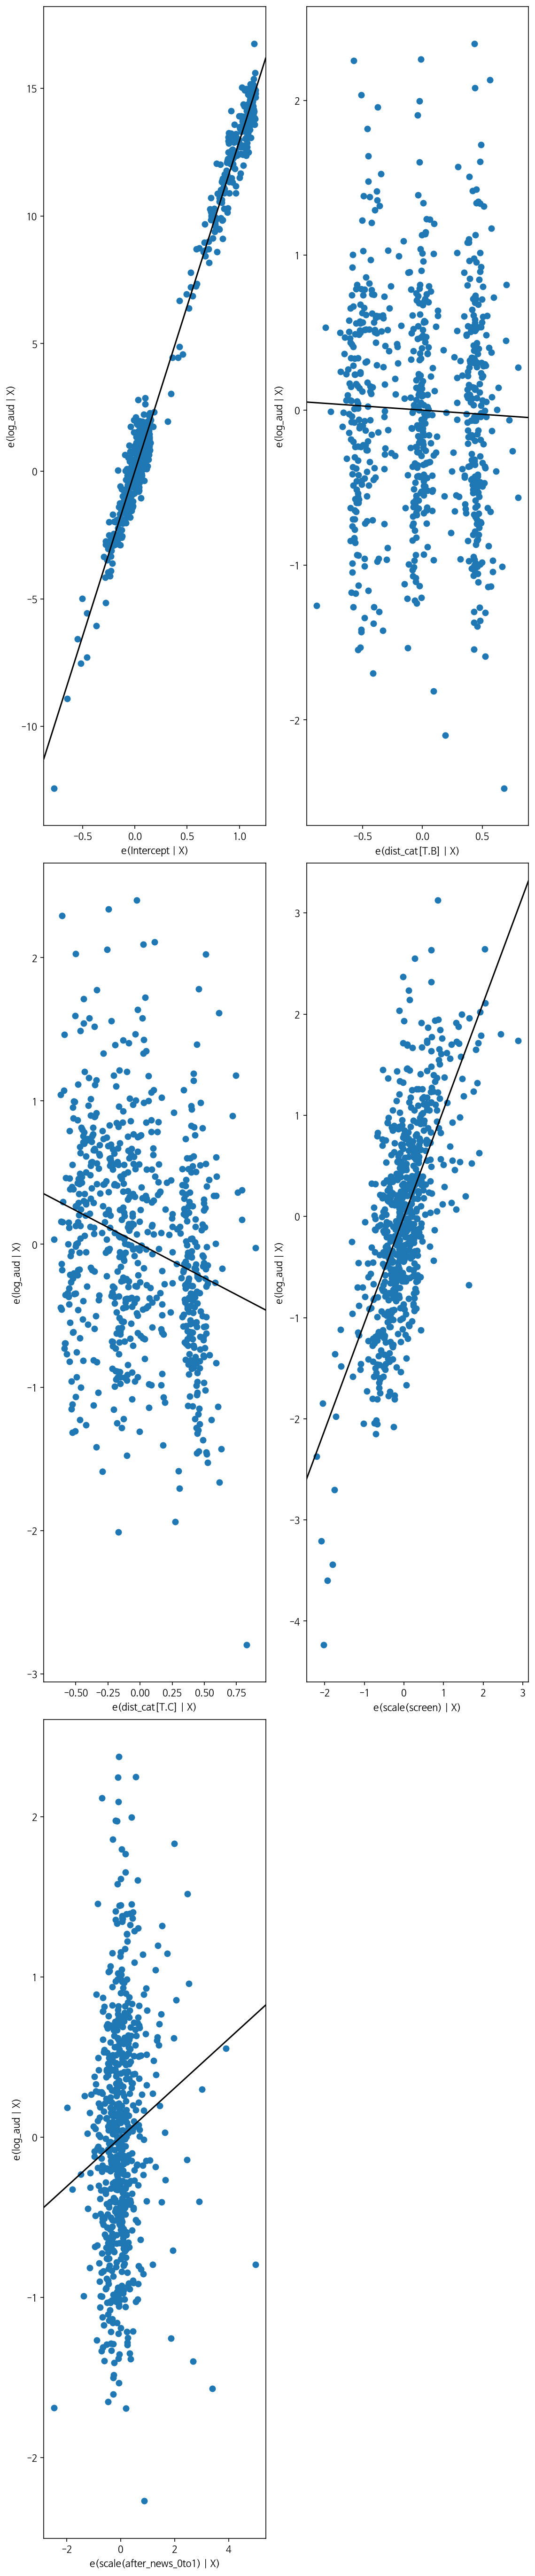

In [81]:
fig = plt.figure(figsize=(8, 40))
sm.graphics.plot_partregress_grid(resultF, fig=fig)
fig.suptitle("")
plt.show()

### modelG

In [33]:
df4 = df3.copy()

In [36]:
feature_namesG = ['screen', 'after_news_0to1']
feature_namesG = ["scale({})".format(name) for name in feature_namesG] + ['dist_cat', 'nation']
modelG = sm.OLS.from_formula("log_aud ~ scale(screen) + dist_cat + scale(np.log(after_news_0to1)) + nation", data=df3)
resultG = modelG.fit()
print(resultG.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     331.9
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          4.59e-281
Time:                        10:31:00   Log-Likelihood:                -1016.6
No. Observations:                 925   AIC:                             2053.
Df Residuals:                     915   BIC:                             2102.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [84]:
# kfold G

from sklearn.model_selection import KFold
ls_olsG = []
kfold_dict['G'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df4)):
    df_train = df4.iloc[idx_train]
    df_test = df4.iloc[idx_test]

    modelG = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_namesG), data=df_train)
    resultG = modelG.fit()

    predG = resultG.predict(df_test[['screen', 'dist_cat', 'after_news_0to1', 'nation']])
    rssG = ((df_test['log_aud'] - predG) ** 2).sum()
    tssG = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquaredG = 1 - rssG/tssG

    scores[i] = rsquaredG
    kfold_dict['G'].append(rsquaredG)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(resultG.rsquared, rsquaredG))
    ls_olsG.append({
        "cv" : i,
        "train_r2" : resultG.rsquared,
        "test_r2" : rsquaredG,
        "model" : resultG
    })

kfold_dict_avr.append(sum(kfold_dict['G'])/10)

학습 R2 = 0.75274774, 검증 R2 = 0.79082098
학습 R2 = 0.76010631, 검증 R2 = 0.72017090
학습 R2 = 0.74568830, 검증 R2 = 0.84504080
학습 R2 = 0.76291200, 검증 R2 = 0.69166278
학습 R2 = 0.75632206, 검증 R2 = 0.76605648
학습 R2 = 0.76294689, 검증 R2 = 0.69220131
학습 R2 = 0.76154619, 검증 R2 = 0.66665840
학습 R2 = 0.76064790, 검증 R2 = 0.72264055
학습 R2 = 0.75572355, 검증 R2 = 0.77017886
학습 R2 = 0.76024795, 검증 R2 = 0.73334819


In [85]:
df_olsG = pd.DataFrame(ls_olsG)
df_olsG

cv  train_r2   test_r2                                              model
0   0  0.752748  0.790821  <statsmodels.regression.linear_model.Regressio...
1   1  0.760106  0.720171  <statsmodels.regression.linear_model.Regressio...
2   2  0.745688  0.845041  <statsmodels.regression.linear_model.Regressio...
3   3  0.762912  0.691663  <statsmodels.regression.linear_model.Regressio...
4   4  0.756322  0.766056  <statsmodels.regression.linear_model.Regressio...
5   5  0.762947  0.692201  <statsmodels.regression.linear_model.Regressio...
6   6  0.761546  0.666658  <statsmodels.regression.linear_model.Regressio...
7   7  0.760648  0.722641  <statsmodels.regression.linear_model.Regressio...
8   8  0.755724  0.770179  <statsmodels.regression.linear_model.Regressio...
9   9  0.760248  0.733348  <statsmodels.regression.linear_model.Regressio...

In [86]:
np.average(kfold_dict['G'])

0.73987792495863

In [37]:
predG =  resultG.predict(X_test[["screen", "dist_cat", 'after_news_0to1', 'nation']])
rssG = ((y_test.log_aud - predG) ** 2).sum()
tssG = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredG = 1 - rssG/tssG
rsquaredG

0.7522569767967286

In [88]:
sm.stats.anova_lm(resultG)

df      sum_sq     mean_sq            F  \
dist_cat                  2.0  368.866252  184.433126   351.014344   
nation                    5.0   88.460957   17.692191    33.671895   
scale(screen)             1.0  631.176283  631.176283  1201.258874   
scale(after_news_0to1)    1.0    4.473007    4.473007     8.513057   
Residual                656.0  344.681443    0.525429          NaN   

                               PR(>F)  
dist_cat                2.240400e-104  
nation                   1.212630e-30  
scale(screen)           2.197248e-150  
scale(after_news_0to1)   3.646714e-03  
Residual                          NaN

In [ ]:
### model G_1

### modelH

In [39]:
dfH = df4.copy()

In [112]:
feature_namesH = ['screen', 'after_news_0to1',
                  'rating_audiences', 'audience_rating']
feature_namesH = ["scale({})".format(name)
                  for name in feature_namesH] + ['dist_cat', 'nation']
modelH = sm.OLS.from_formula(
    "log_aud ~ scale(screen**(4/7)) + scale(np.log(screen)) + dist_cat + scale(np.log(after_news_0to1)) + scale(rating_audiences**(3/7)) + scale(rating_audiences) + C(sequel) ", data=dfH)
resultH = modelH.fit()
print(resultH.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     580.2
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:28:50   Log-Likelihood:                -853.65
No. Observations:                 925   AIC:                             1725.
Df Residuals:                     916   BIC:                             1769.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [ ]:
### 전문가 평점보다는 관객수 반응이 매우 중요하다!

In [91]:
# kfold H

from sklearn.model_selection import KFold
ls_olsH = []
kfold_dict['H'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(dfH)):
    df_train = dfH.iloc[idx_train]
    df_test = dfH.iloc[idx_test]

    modelH = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_namesH), data=df_train)
    resultH = modelH.fit()

    predH = resultH.predict(df_test[['screen', 'dist_cat', 'after_news_0to1', 'rating_audiences', 'audience_rating', 'nation']])
    rssH = ((df_test['log_aud'] - predH) ** 2).sum()
    tssH = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquaredH = 1 - rssH/tssH

    scores[i] = rsquaredH
    kfold_dict['H'].append(rsquaredH)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(resultH.rsquared, rsquaredH))
    ls_olsH.append({
        "cv" : i,
        "train_r2" : resultH.rsquared,
        "test_r2" : rsquaredH,
        "model" : resultH
    })

kfold_dict_avr.append(sum(kfold_dict['H'])/10)

학습 R2 = 0.76653563, 검증 R2 = 0.80061834
학습 R2 = 0.77303073, 검증 R2 = 0.73611526
학습 R2 = 0.76252058, 검증 R2 = 0.82538424
학습 R2 = 0.77494922, 검증 R2 = 0.71786881
학습 R2 = 0.76982631, 검증 R2 = 0.77715684
학습 R2 = 0.77633459, 검증 R2 = 0.70089970
학습 R2 = 0.77646772, 검증 R2 = 0.65733888
학습 R2 = 0.77245869, 검증 R2 = 0.74954283
학습 R2 = 0.76871255, 검증 R2 = 0.78652643
학습 R2 = 0.77163133, 검증 R2 = 0.75940732


In [92]:
df_olsH = pd.DataFrame(ls_olsH)
df_olsH

cv  train_r2   test_r2                                              model
0   0  0.766536  0.800618  <statsmodels.regression.linear_model.Regressio...
1   1  0.773031  0.736115  <statsmodels.regression.linear_model.Regressio...
2   2  0.762521  0.825384  <statsmodels.regression.linear_model.Regressio...
3   3  0.774949  0.717869  <statsmodels.regression.linear_model.Regressio...
4   4  0.769826  0.777157  <statsmodels.regression.linear_model.Regressio...
5   5  0.776335  0.700900  <statsmodels.regression.linear_model.Regressio...
6   6  0.776468  0.657339  <statsmodels.regression.linear_model.Regressio...
7   7  0.772459  0.749543  <statsmodels.regression.linear_model.Regressio...
8   8  0.768713  0.786526  <statsmodels.regression.linear_model.Regressio...
9   9  0.771631  0.759407  <statsmodels.regression.linear_model.Regressio...

In [152]:
np.average(kfold_dict['H'])

0.7510858657109907

In [154]:
predH =  resultH.predict(X_test[['screen', 'dist_cat', 'after_news_0to1', 'rating_audiences', 'audience_rating', 'sequel']])
rssH = ((y_test.log_aud - predH) ** 2).sum()
tssH = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredH = 1 - rssH/tssH
rsquaredH

0.8309589606064365

In [95]:
sm.stats.anova_lm(resultH)

df      sum_sq     mean_sq            F  \
dist_cat                   2.0  368.866252  184.433126   367.387672   
nation                     5.0   88.460957   17.692191    35.242546   
scale(screen)              1.0  631.176283  631.176283  1257.292498   
scale(after_news_0to1)     1.0    4.473007    4.473007     8.910155   
scale(rating_audiences)    1.0    8.019028    8.019028    15.973769   
scale(audience_rating)     1.0    8.346378    8.346378    16.625845   
Residual                 654.0  328.316036    0.502012          NaN   

                                PR(>F)  
dist_cat                 1.130474e-107  
nation                    5.851752e-32  
scale(screen)            1.925444e-154  
scale(after_news_0to1)    2.941751e-03  
scale(rating_audiences)   7.153629e-05  
scale(audience_rating)    5.113639e-05  
Residual                           NaN

### modelI

In [96]:
feature_namesI = ['screen', 'after_news_0to1', 'rating_audiences', 'audience_rating']
feature_namesI = ["scale({})".format(name) for name in feature_namesH] + ['dist_cat', 'nation', 'sequel']
modelI = sm.OLS.from_formula("log_aud ~ scale(screen) + dist_cat + scale(np.log(after_news_0to1))  + C(sequel) + scale(rating_audiences) + scale(audience_rating)", data=dfH)
resultI = modelI.fit()
print(resultI.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     386.7
Date:                Sat, 11 Apr 2020   Prob (F-statistic):          7.82e-241
Time:                        14:53:49   Log-Likelihood:                -771.22
No. Observations:                 739   AIC:                             1558.
Df Residuals:                     731   BIC:                             1595.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [97]:
predI =  resultI.predict(X_test[['screen', 'dist_cat', 'after_news_0to1', 'rating_audiences', 'audience_rating', 'nation', 'sequel']])
rssI = ((y_test.log_aud - predI) ** 2).sum()
tssI = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredI = 1 - rssI/tssI
rsquaredI

0.7576227139660263

### model J

In [40]:
dfJ = dfH.copy()

In [41]:
dfJ['actor_count'] = 0
dfJ['actor_power_perA'] = 0

In [42]:
# index 576번이 없어서 인덱스 리셋
dfJ = dfJ.reset_index(drop = True)

In [205]:
#없는 것 확인
dfJ['starring_actors'][574:578]

574    시영준,정혜원,이세은
575    박영남,강희선,김환진
576    김혜수,김고은,엄태구
577        나문희,이제훈
Name: starring_actors, dtype: object

In [43]:
for i in range(len(dfJ['starring_actors'])):
    dfJ['actor_count'][i] = len(dfJ['starring_actors'].loc[i].split(','))
    dfJ['actor_power_perA'] = dfJ['actor_power']/dfJ['actor_count']
    
    
dfJ[['title', 'actor_power', 'starring_actors', 'actor_count', 'actor_power_perA']].tail()

title  actor_power        starring_actors  actor_count  actor_power_perA
920    명당     25917574             조승우,지성,김성균            3      8.639191e+06
921    버닝     14355109          유아인,스티븐 연,전종서            3      4.785036e+06
922    후드     12312407    태런 에저튼,제이미 폭스,벤 멘델슨            3      4.104136e+06
923     룸            0  브리 라슨,제이콥 트렘블레이,조안 알렌            3      0.000000e+00
924    인랑     31593235            강동원,한효주,정우성            3      1.053108e+07

In [111]:
feature_namesJ = ['screen', 'after_news_0to1', 'rating_audiences', 'audience_rating', 'director_power' ]
feature_namesJ = ["scale({})".format(name) for name in feature_namesJ] + ['dist_cat', 'nation', 'sequel']
modelJ = sm.OLS.from_formula("log_aud ~ scale(screen) + dist_cat + scale(np.log(after_news_0to1))  + C(sequel) + scale(rating_audiences) + scale(audience_rating) + scale(np.log(actor_power_perA_to1)**1/4)", data=dfJ)
resultJ = modelJ.fit()
print(resultJ.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     394.8
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          1.05e-290
Time:                        11:27:04   Log-Likelihood:                -997.22
No. Observations:                 925   AIC:                             2012.
Df Residuals:                     916   BIC:                             2056.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [68]:
dfJ['actor_power_perA_to1'] = dfJ['actor_power_perA'].apply(lambda data: data if data > 0 else 1.0)

In [77]:
dfJ['actor_power_to1'] = dfJ['actor_power'].apply(lambda data: data if data > 0 else 1.0)

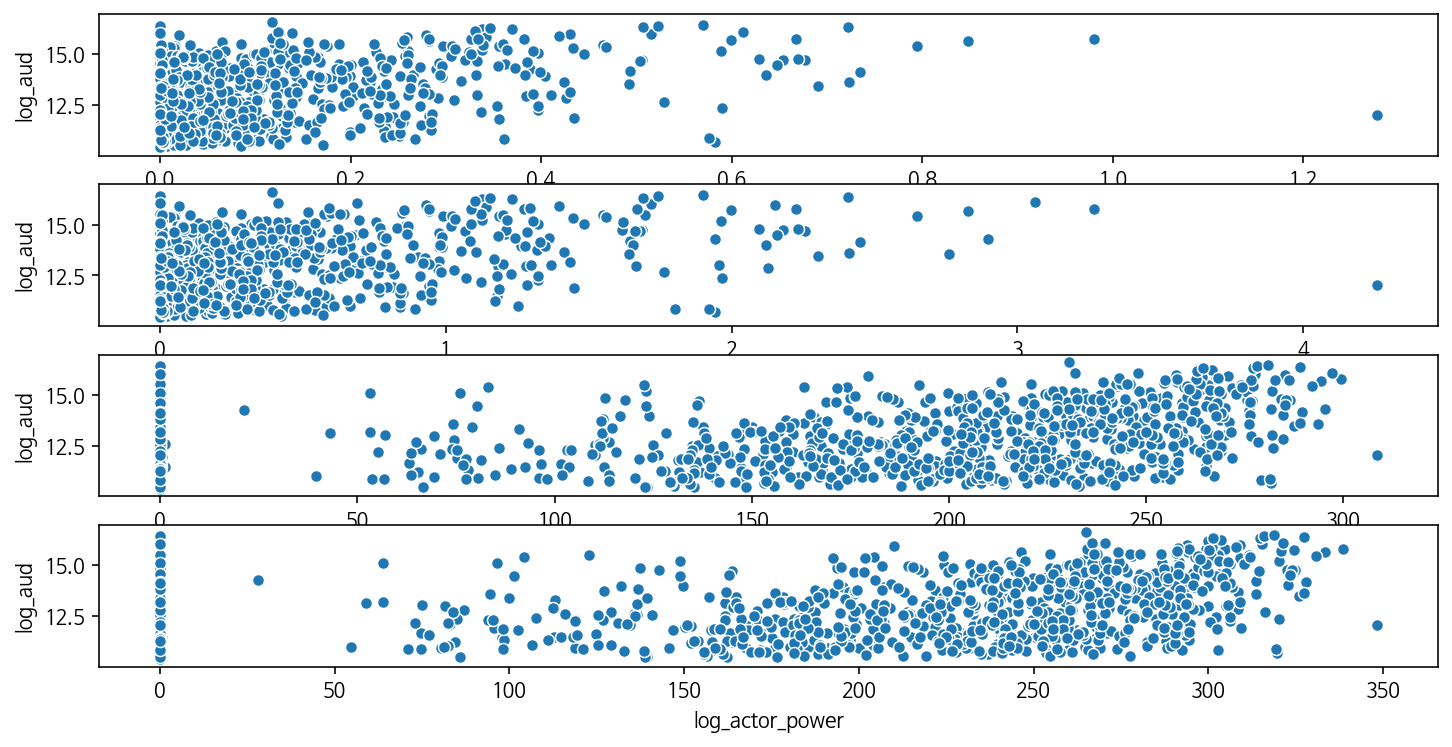

In [90]:
plt.figure(figsize=(12, 6))
plt.subplot(411)
sns.scatterplot(x="actor_power", y="log_aud", data=dfJ)
plt.subplot(412)
sns.scatterplot(x="actor_power_perA", y="log_aud", data=dfJ)
plt.subplot(413)
sns.scatterplot(x="log_actor_power_perA", y="log_aud", data=dfJ)
plt.subplot(414)
sns.scatterplot(x="log_actor_power", y="log_aud", data=dfJ)
plt.show()

In [94]:
dfJ['log_actor_power_perA'] = np.log(dfJ['actor_power_perA_to1'])**2

In [92]:
dfJ['log_actor_power'] = np.log(dfJ['actor_power_to1'])

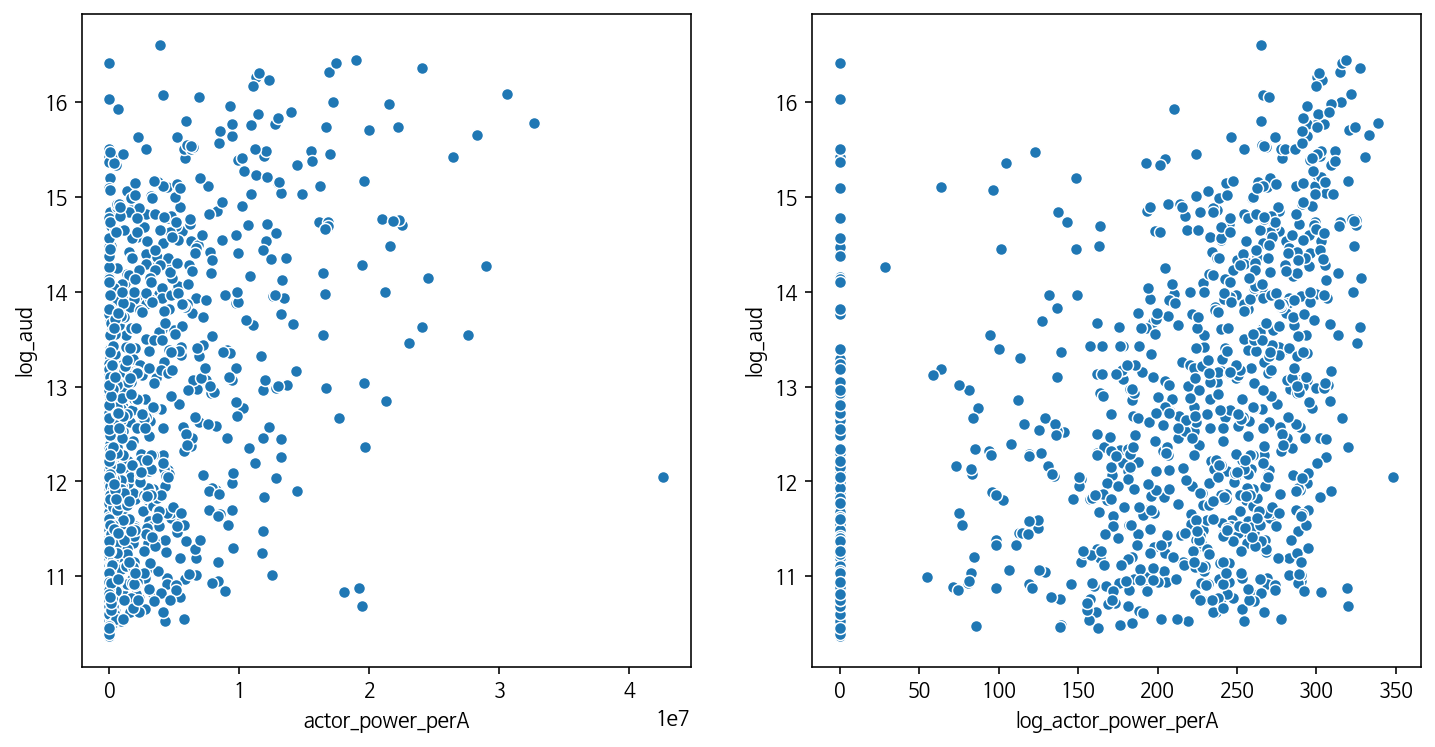

In [95]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="actor_power_perA", y="log_aud", data=dfJ)
plt.subplot(122)
sns.scatterplot(x="log_actor_power_perA", y="log_aud", data=dfJ)
plt.show()

In [113]:
dfK = dfJ.copy()

In [131]:
feature_namesK = ['screen', 'after_news_0to1', 'rating_audiences', 'audience_rating', 'director_power' ]
feature_namesK = ["scale({})".format(name) for name in feature_namesJ] + ['dist_cat', 'nation', 'sequel']
modelK = sm.OLS.from_formula("log_aud ~ scale(screen**(4/7)) + scale(np.log(screen)) + dist_cat + scale(np.log(after_news_0to1)) + scale(rating_audiences**(3/7))  + C(sequel)  + scale(audience_rating) + scale(actor_power)*genre + scale(expert_rating)*scale(director_power)", data=dfK)
resultK = modelK.fit()
print(resultK.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     113.7
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          7.41e-311
Time:                        11:47:07   Log-Likelihood:                -868.52
No. Observations:                 925   AIC:                             1815.
Df Residuals:                     886   BIC:                             2003.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

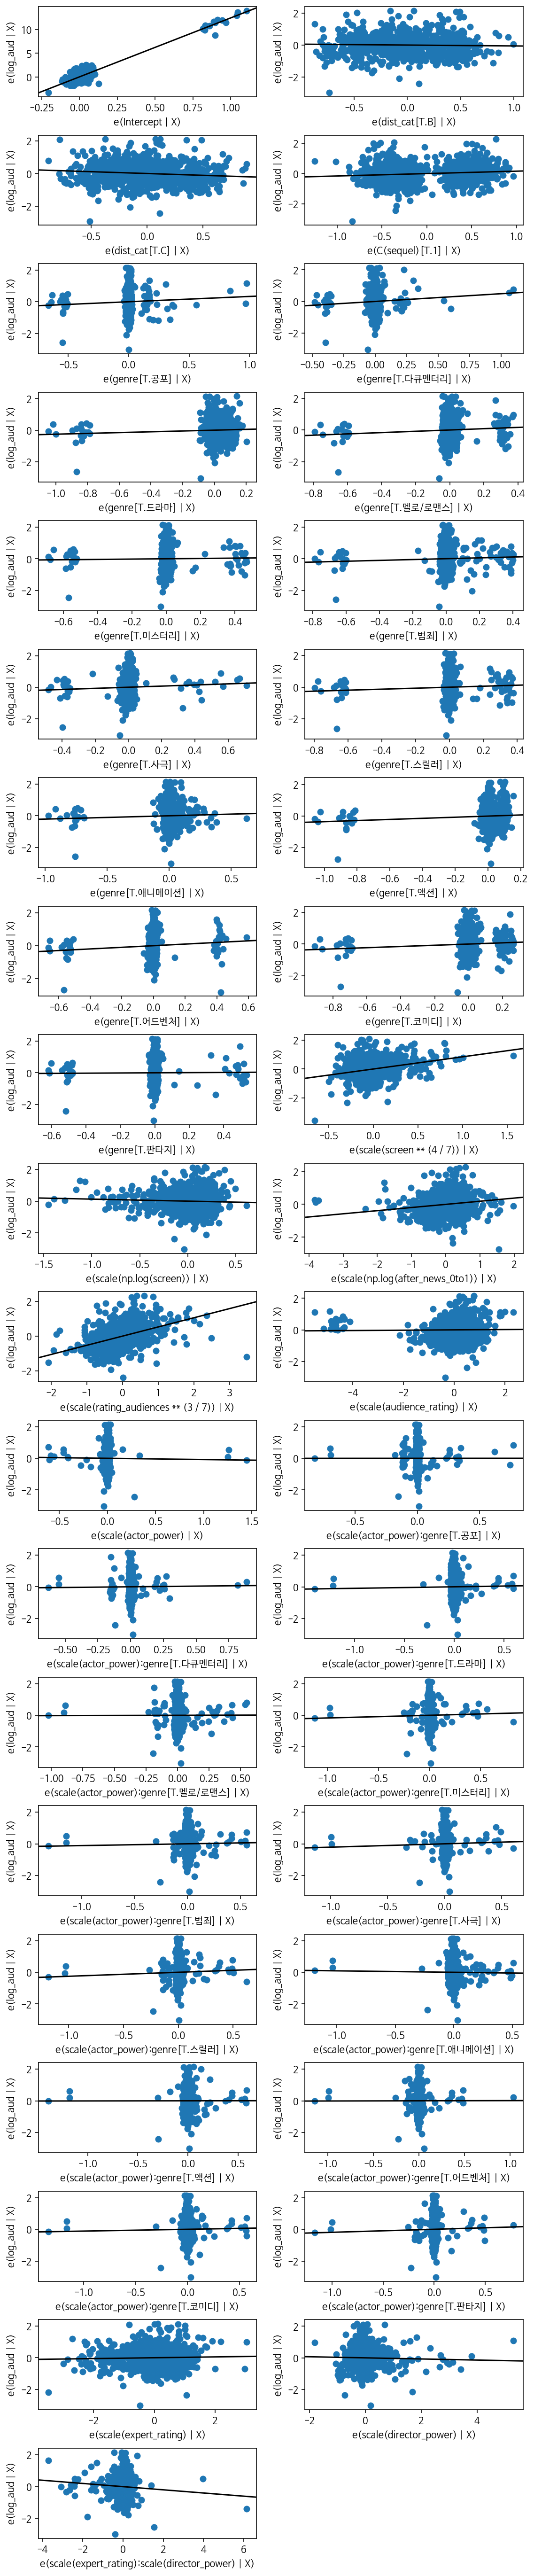

In [133]:
fig = plt.figure(figsize=(8, 40))
sm.graphics.plot_partregress_grid(resultK, fig=fig)
fig.suptitle("")
plt.show()

In [137]:
predK =  resultK.predict(X_test[['screen', 'dist_cat', 'after_news_0to1', 'rating_audiences', 'audience_rating', 'actor_power', 'genre', 'expert_rating', 'director_power', 'sequel']])
rssK = ((y_test.log_aud - predK) ** 2).sum()
tssK = ((y_test.log_aud - y_test.log_aud.mean()) ** 2).sum()

rsquaredK = 1 - rssK/tssK
rsquaredK

0.830601945067009

### 5. 앞으로 할 과제
- 모형 진단(잔차정규성, 이분산성)과 수정
- 다중공선성 제거 위해 VIF 수치 확인
- 개봉일을 확인해서 휴일/명절 변수 추가할 수 있는지 확인 -> 별로 영향이 없음
- 카테고리 변수 구분을 정리(EX: 장르)

### 6. 참고문헌
- 뉴스 기사
    - 영화흥행 순위(매출 VS. 관객수)(https://news.mt.co.kr/mtview.php?no=2019112914134099089)
- 논문
    - 김은미,〈한국 영화의 흥행 결정 요인에 관한 연구〉, 2003
        - `스타파워 산출시 배우 수 참고(남주, 여주,남조주, 여조주)`
        - 마케팅과 홍보 영역 : 마케팅 비용 자료 얻을 수 없어 `홍보기사 개수` 포함
        - 한국 제작 영화 VS. 헐리우드 영화 흥행 요소 분석
    - 박승현, 정완규 〈한국 영화시장의 흥행결정 요인에 관한 연구: 2006-2008년 개봉작품을 중심으로〉, 2009
        - `매년 흥행 순위 100위`(기준: 한국영화연감, 영진위 자료 바탕, 전국 관객 수 기준)
        - `배급사 파워 구분` :
        - 헐리우드 배급사 자회사 설치/직배사
        - 한국메이저 배급사(CJ ENM, 쇼박스, 롯데엔터테인먼트)
        - 국내 미니 메이저 배급사(300편 중 20편 이상 배급)
        - 국내 독립 배급사(10편 이상의 배급 편수)
        - 개봉시점 : 여름방학 7-8월, 겨울방학 12-2월 시즌
   - 김유진, 권오경,〈영화 투자자를 위한 흥행성과 예측지표 발굴〉, 2017
        - `상호작용 변수 적용 : 계절 * 장르`
        - `원작여부, 실화 여부, 시리즈 여부` 구분 참고
        - 2010-2015 개봉영화 중 상업영화 + 매출액 천만 원 이상
    - 문병준, 서혜미, 김혜정, 〈한국 영화시장의 흥행에 관한 통계분석 : 2006 ~ 2010년 흥행 작품을 중심으로〉, 2011
        - 독립 변수들 : 개봉스크린 규모, 메이저 배급사, 스타배우, 관람등급, 상영시간, `비평가&관람객 평가`, 장르, 개봉 첫주 상영관수(`네이버 평점등록 관람객 수`로 대체), 수상경력, 애국심 자극 여부, 국적

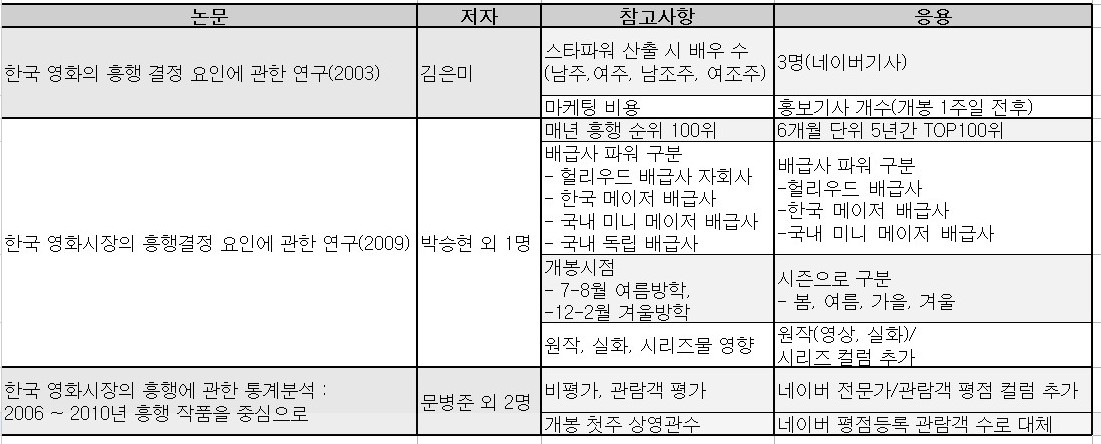

In [135]:
references = Image("./mid_presentatino_pic/references.jpg")
references